In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def give_centeroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([[sum_x/length, sum_y/length, sum_z/length]])

In [3]:
def give_next_neighbours_barycenter_indices(batch_x, input_barycenter, remaining_indices, no_of_barycenetrs_required):
    

  num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)
    
  wasserDistance = []
  distance_cum_index = np.array([])

  for j in remaining_indices:
    
    wassDistance = dist = np.linalg.norm(batch_x[j]-input_barycenter)

    
    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)
   
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  
  distance_cum_index = np.array(distance_cum_index)
  
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
  
    
  A = np.array([])
  for i in range(num_neighbours):
    if(i >= distance_cum_index[:,1].shape[0]):
        break
    A = np.concatenate((A, batch_x[int(distance_cum_index[:,1][i])]), axis = 0 )
  
  A = A.reshape(int(A.shape[0]/3) , 3)
  
  #print("The shape of A is ")
  #print(A.shape)
  next_barycenter = give_centeroid(A) 
  
  next_barycenter = np.array(next_barycenter)
  #print(next_barycenter.shape)
  next_barycenter = next_barycenter.reshape(next_barycenter.shape[0]* next_barycenter.shape[1])
  #print(next_barycenter.shape)  
  return A, next_barycenter, remaining_indices


In [4]:
def get_convergent_barycenters(point_cloud, no_of_barycenetrs_required, initial_pt):   
    
    no_neighbours = int(point_cloud.shape[0] / no_of_barycenetrs_required)
    
    #num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)

    
    bary = initial_pt
    rem_indices = np.array(range(0,point_cloud.shape[0]))
    #print("Size of batch : ", point_cloud.shape[0])
    sampled_barycenters = np.array([])
    sampled_barycenters = torch.tensor(sampled_barycenters)
    covered_indices = np.array([])

    for i in range(int(point_cloud.shape[0])):

        if(len(rem_indices) < 2):
            #print("END")
            break

        #print("Iteration number : ", i+1)
        #print("Input barycenter : ")


        old_bary = bary



        neighbours, bary, rem_indices = give_next_neighbours_barycenter_indices(point_cloud, bary, rem_indices, no_neighbours)


        wassDistance = np.linalg.norm(old_bary - bary)  

        covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)


        #print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
        if(wassDistance == 0.0):

            unique_covered_indices = np.unique(covered_indices, axis=0)
            sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

            s1 = set(rem_indices)
            s2 = set(unique_covered_indices)
            rem_set = s1 - s2
            rem_inds = list(rem_set)
            #rem_indices = rem_set
            rem_indices = rem_indices[no_neighbours:]

            #print("Sampled barycenters are")
            #print(sampled_barycenters)
    sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)
    
    return sampled_barycenters

In [5]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [6]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


# Torus in 3D

In [7]:
x, y, z = sp.symbols('x y z')


In [8]:
## Torus
R = 1.5
r = 0.7
expr_torus = (x**2 + y**2 + z**2 + R**2 - r**2)**2 - 4*R**2*(x**2 + y**2)


In [9]:
expr_torus

-9.0*x**2 - 9.0*y**2 + 3.0976*(0.568181818181818*x**2 + 0.568181818181818*y**2 + 0.568181818181818*z**2 + 1)**2

In [10]:
poly_torus = sp.Poly(expr_torus, x, y, z)

In [11]:
sp.expand(expr_torus)

1.0*x**4 + 2.0*x**2*y**2 + 2.0*x**2*z**2 - 5.48*x**2 + 1.0*y**4 + 2.0*y**2*z**2 - 5.48*y**2 + 1.0*z**4 + 3.52*z**2 + 3.0976

In [12]:
#Convert sympy polynomial to minterpy polynomial

newt_poly_torus = sympy_to_mp(poly_torus, mp.NewtonPolynomial)

# Trials on Torus : 

In [13]:
#Sample points on the zero isocontour
def points_on_torus(num_points):
    
    point_data_torus = sample_points_on_poly(num_points,        # Number of points to be sampled
                                       newt_poly_torus,  # Polynomial in Newton basis
                                       bounds=3.0, # Boundary of the Cubic domain to be sampled
                                       tol=1e-15)  # Tolerance in solution
    
    return point_data_torus

# 1. 1000 barycenters from 10000 points

In [14]:
#Sample points on the zero isocontour

point_data_torus = sample_points_on_poly(10000,        # Number of points to be sampled
                                   newt_poly_torus,  # Polynomial in Newton basis
                                   bounds=3.0, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [15]:
point_data_torus.shape

(10000, 3)

In [16]:
x_t = point_data_torus[:,0]
y_t = point_data_torus[:,1]
z_t = point_data_torus[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# demo of barycenter convergence on a torus


In [17]:
no_of_barycenetrs_required = 50

nachbarn = int(point_data_torus.shape[0] / no_of_barycenetrs_required)

int(nachbarn)

200

In [18]:
#demo of barycenter convergence on a torus

bary = point_data_torus[0]
rem_indices = np.array(range(0,point_data_torus.shape[0]))
print("Size of batch : ", point_data_torus.shape[0])
sampled_barycenters = np.array([])
sampled_barycenters = torch.tensor(sampled_barycenters)
covered_indices = np.array([])

for i in range(int(point_data_torus.shape[0])):
        
    if(len(rem_indices) < 2):
        print("END")
        break
    
    print("Iteration number : ", i+1)
    print("Input barycenter : ")
    print(bary)

    old_bary = bary
    
    
    
    neighbours, bary, rem_indices = give_next_neighbours_barycenter_indices(point_data_torus, bary, rem_indices, nachbarn)
    
    print("remaining indices")
    print(rem_indices)
    print("neighbours found : ")
    print(neighbours)

    
    wassDistance = np.linalg.norm(old_bary - bary)  
    
    covered_indices = np.concatenate((covered_indices, rem_indices[:nachbarn] ) ,axis = 0)
    #print("covered indices")
    #print(covered_indices)

    print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
    if(wassDistance == 0.0):

        unique_covered_indices = np.unique(covered_indices, axis=0)
        sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

        s1 = set(rem_indices)
        s2 = set(unique_covered_indices)
        rem_set = s1 - s2
        rem_inds = list(rem_set)
        rem_indices = rem_indices[nachbarn:]
        print("Sampled barycenters are")
        print(sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3))
sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)


Size of batch :  10000
Iteration number :  1
Input barycenter : 
[ 1.71638583 -1.26730025 -0.29768437]
remaining indices
[   0 8406 1003 ... 1282 3762 2707]
neighbours found : 
[[ 1.71638583 -1.26730025 -0.29768437]
 [ 1.74321812 -1.27270713 -0.23777984]
 [ 1.76569701 -1.220685   -0.26823262]
 [ 1.71582199 -1.31151312 -0.2342107 ]
 [ 1.68741049 -1.24057798 -0.36976165]
 [ 1.75575295 -1.26533657 -0.22100553]
 [ 1.72818792 -1.19976385 -0.35411729]
 [ 1.73615915 -1.18078754 -0.36114575]
 [ 1.75802416 -1.17403645 -0.3361544 ]
 [ 1.67045342 -1.23645701 -0.39445436]
 [ 1.79392425 -1.19795834 -0.24116867]
 [ 1.78179709 -1.24296147 -0.19427923]
 [ 1.67055204 -1.36737907 -0.23657267]
 [ 1.770439   -1.26591355 -0.17999376]
 [ 1.79581627 -1.21403936 -0.21023797]
 [ 1.63418859 -1.27749431 -0.40027843]
 [ 1.69229401 -1.36707177 -0.18362228]
 [ 1.67064308 -1.19680332 -0.42647082]
 [ 1.81229888 -1.20369138 -0.18315161]
 [ 1.70400136 -1.36027386 -0.16465586]
 [ 1.82417055 -1.18361081 -0.18714745]
 [ 1

remaining indices
[5079 7397 8233 ... 3762 1282 2707]
neighbours found : 
[[ 1.50390826 -0.98285096 -0.63406175]
 [ 1.55869452 -0.94732322 -0.62050676]
 [ 1.38180868 -1.13614112 -0.63759621]
 [ 1.36106203 -1.19728578 -0.62625965]
 [ 1.41464438 -1.07134887 -0.64391419]
 [ 1.34793536 -1.35148246 -0.56824318]
 [ 1.34951572 -1.21720864 -0.62392627]
 [ 1.35060214 -1.17354392 -0.63745434]
 [ 1.34912113 -1.17232319 -0.63832137]
 [ 1.35069413 -1.41926624 -0.52828234]
 [ 1.32460162 -1.28691669 -0.60804577]
 [ 1.32451672 -1.31977374 -0.59434746]
 [ 1.43893038 -0.98446046 -0.6562949 ]
 [ 1.31170805 -1.26487059 -0.62143065]
 [ 1.37116218 -1.0601955  -0.66000143]
 [ 1.30999044 -1.3015853  -0.60812679]
 [ 1.30996296 -1.34883263 -0.58771374]
 [ 1.36334608 -1.06365876 -0.66141818]
 [ 1.30533157 -1.27467118 -0.62025934]
 [ 1.61895792 -0.87287186 -0.61228501]
 [ 1.32971825 -1.12908795 -0.65594237]
 [ 1.35594239 -1.50318694 -0.4636984 ]
 [ 1.30417029 -1.36141585 -0.58442507]
 [ 1.66831191 -0.84904791 -0.

remaining indices
[4903 1492 3440 ... 9895 6356 4971]
neighbours found : 
[[ 1.30557456 -1.09978656 -0.66867479]
 [ 1.32971825 -1.12908795 -0.65594237]
 [ 1.27397918 -1.18867565 -0.65668878]
 [ 1.36334608 -1.06365876 -0.66141818]
 [ 1.34912113 -1.17232319 -0.63832137]
 [ 1.35060214 -1.17354392 -0.63745434]
 [ 1.37116218 -1.0601955  -0.66000143]
 [ 1.38180868 -1.13614112 -0.63759621]
 [ 1.28583942 -1.00035041 -0.6879854 ]
 [ 1.20074689 -1.1773902  -0.67601266]
 [ 1.2980958  -0.99918826 -0.68623864]
 [ 1.36106203 -1.19728578 -0.62625965]
 [ 1.2819861  -1.22856506 -0.64345033]
 [ 1.28499581 -0.98298477 -0.69000641]
 [ 1.34951572 -1.21720864 -0.62392627]
 [ 1.19030085 -1.19290944 -0.67506033]
 [ 1.41464438 -1.07134887 -0.64391419]
 [ 1.2601976  -0.98304765 -0.69306722]
 [ 1.23983577 -1.23434566 -0.65402017]
 [ 1.23895473 -1.24390095 -0.65164739]
 [ 1.36392304 -0.97509722 -0.67734816]
 [ 1.31170805 -1.26487059 -0.62143065]
 [ 1.30533157 -1.27467118 -0.62025934]
 [ 1.12026664 -1.1067544  -0.

remaining indices
[9053 5776 6370 ... 1436 6174 3631]
neighbours found : 
[[ 0.76941654 -0.86154985 -0.60913722]
 [ 0.73046756 -0.88389438 -0.60428298]
 [ 0.73964112 -0.90017465 -0.61467108]
 [ 0.77044384 -0.82853883 -0.59509008]
 [ 0.72409026 -0.88506132 -0.60243067]
 [ 0.73204983 -0.89881341 -0.61144142]
 [ 0.71975403 -0.87507988 -0.59611274]
 [ 0.72379713 -0.85020722 -0.58564794]
 [ 0.73414548 -0.92162783 -0.62169342]
 [ 0.77895528 -0.75847446 -0.56534549]
 [ 0.66320663 -0.93829256 -0.60564815]
 [ 0.67496371 -0.79854525 -0.5324548 ]
 [ 0.69300446 -0.77609627 -0.52804679]
 [ 0.70381776 -0.7505473  -0.51776984]
 [ 0.71846808 -1.02092192 -0.65321702]
 [ 0.74394251 -0.72369839 -0.52577833]
 [ 0.62026295 -0.82587201 -0.52132151]
 [ 0.60600331 -0.8561461  -0.5352792 ]
 [ 0.71830155 -1.03454495 -0.65737408]
 [ 0.6570293  -0.77134596 -0.50305861]
 [ 0.58823845 -0.91671147 -0.56679258]
 [ 0.62389658 -0.79283621 -0.49879841]
 [ 0.58005107 -0.88176433 -0.54071462]
 [ 0.67526732 -0.72620226 -0.

remaining indices
[9375  260 4590 ... 2140 4897 8326]
neighbours found : 
[[ 0.62026295 -0.82587201 -0.52132151]
 [ 0.60600331 -0.8561461  -0.5352792 ]
 [ 0.62389658 -0.79283621 -0.49879841]
 [ 0.58005107 -0.88176433 -0.54071462]
 [ 0.54138915 -0.84850225 -0.49645303]
 [ 0.56624121 -0.88721458 -0.53828741]
 [ 0.59833918 -0.77778925 -0.47006263]
 [ 0.55611876 -0.88497608 -0.53212809]
 [ 0.67496371 -0.79854525 -0.5324548 ]
 [ 0.52758742 -0.86755859 -0.50512192]
 [ 0.6570293  -0.77134596 -0.50305861]
 [ 0.54824959 -0.79976906 -0.4568608 ]
 [ 0.58823845 -0.91671147 -0.56679258]
 [ 0.50327052 -0.85839062 -0.48478966]
 [ 0.52541156 -0.9056643  -0.53368899]
 [ 0.69300446 -0.77609627 -0.52804679]
 [ 0.5220444  -0.79603321 -0.43547179]
 [ 0.53305739 -0.93217321 -0.55531401]
 [ 0.70381776 -0.7505473  -0.51776984]
 [ 0.67526732 -0.72620226 -0.4812204 ]
 [ 0.72379713 -0.85020722 -0.58564794]
 [ 0.65103718 -0.71060223 -0.44992317]
 [ 0.71975403 -0.87507988 -0.59611274]
 [ 0.64652223 -0.70742871 -0.

remaining indices
[9008  823 3883 ... 5854 3797  835]
neighbours found : 
[[-0.03885373 -1.14631711 -0.60446143]
 [-0.0191732  -1.15970164 -0.61180459]
 [-0.01594978 -1.13192546 -0.59548622]
 [-0.0132867  -1.11279071 -0.58320698]
 [-0.03820707 -1.19567175 -0.63067852]
 [-0.02098594 -1.0971066  -0.57257191]
 [ 0.02704208 -1.18565376 -0.62560387]
 [-0.04293213 -1.06653418 -0.55032303]
 [ 0.0767483  -1.14714475 -0.60604983]
 [-0.11649336 -1.10498956 -0.58203702]
 [-0.12442311 -1.18063627 -0.62621096]
 [-0.03460248 -1.24383842 -0.65163452]
 [ 0.01703572 -1.0570614  -0.54215033]
 [ 0.08855982 -1.09497572 -0.57344471]
 [-0.06082574 -1.0436902  -0.53234803]
 [-0.00702645 -1.26904438 -0.66080896]
 [-0.16037638 -1.13906679 -0.6063918 ]
 [-0.16549328 -1.13130425 -0.60232638]
 [ 0.10522782 -1.09257287 -0.57279769]
 [-0.05845912 -1.28720363 -0.6672935 ]
 [-0.15353246 -1.22985663 -0.64968389]
 [-0.09633552 -1.27808319 -0.66509316]
 [ 0.12456814 -1.20957381 -0.6397872 ]
 [ 0.06352664 -1.28088693 -0.

remaining indices
[9373 2199 7615 ... 7195 2789 7569]
neighbours found : 
[[-0.11649336 -1.10498956 -0.58203702]
 [-0.16549328 -1.13130425 -0.60232638]
 [-0.16037638 -1.13906679 -0.6063918 ]
 [-0.12442311 -1.18063627 -0.62621096]
 [-0.21786595 -1.07983085 -0.57556005]
 [-0.22872984 -1.09266703 -0.58550244]
 [-0.03885373 -1.14631711 -0.60446143]
 [-0.23075348 -1.16127215 -0.62460315]
 [-0.04293213 -1.06653418 -0.55032303]
 [-0.02098594 -1.0971066  -0.57257191]
 [-0.01594978 -1.13192546 -0.59548622]
 [-0.15353246 -1.22985663 -0.64968389]
 [-0.0132867  -1.11279071 -0.58320698]
 [-0.0191732  -1.15970164 -0.61180459]
 [-0.06082574 -1.0436902  -0.53234803]
 [-0.03820707 -1.19567175 -0.63067852]
 [-0.1804255  -1.0205407  -0.52444685]
 [-0.14922232 -1.01038848 -0.51077634]
 [-0.15240505 -1.00385379 -0.50509515]
 [-0.27860764 -1.0716093  -0.57942681]
 [-0.22343829 -1.01213683 -0.52457004]
 [-0.2320778  -1.00958081 -0.52404414]
 [-0.03460248 -1.24383842 -0.65163452]
 [-0.22585688 -1.00135039 -0.

remaining indices
[8216 4875 8766 ...  638 1023 7938]
neighbours found : 
[[-0.7627127  -1.05089173 -0.67037156]
 [-0.74169798 -1.11606966 -0.68148016]
 [-0.80086842 -1.05861307 -0.67839309]
 [-0.80031182 -1.11416955 -0.68816297]
 [-0.81202236 -1.10839821 -0.68857002]
 [-0.82840222 -1.11513512 -0.69116957]
 [-0.68212988 -1.10206058 -0.66964098]
 [-0.69961386 -1.02056172 -0.64885188]
 [-0.69458193 -1.13991205 -0.68024101]
 [-0.75540804 -1.16785659 -0.69144161]
 [-0.76467592 -0.98332802 -0.65215798]
 [-0.8596793  -1.07686251 -0.68927357]
 [-0.86242307 -1.05348292 -0.68615549]
 [-0.83647472 -1.16908241 -0.6972054 ]
 [-0.77863415 -0.96055282 -0.64851205]
 [-0.85183369 -1.15954031 -0.69731983]
 [-0.86614655 -1.1420776  -0.69682172]
 [-0.75419462 -0.93655083 -0.63362182]
 [-0.89335583 -0.97935434 -0.67792713]
 [-0.91640841 -1.1439392  -0.69916123]
 [-0.79077212 -1.24720094 -0.69961423]
 [-0.76237721 -1.26378289 -0.69958601]
 [-0.87116593 -0.93115284 -0.66290034]
 [-0.66620011 -1.25318694 -0.

remaining indices
[1160 6669 7180 ... 2773  638 7938]
neighbours found : 
[[-0.90583822 -1.25546314 -0.69834286]
 [-0.87576848 -1.25705607 -0.69926615]
 [-1.00370821 -1.2541363  -0.69187749]
 [-0.87171953 -1.31626809 -0.69555603]
 [-0.91640841 -1.1439392  -0.69916123]
 [-0.93772871 -1.33675336 -0.68727518]
 [-0.85183369 -1.15954031 -0.69731983]
 [-1.0201919  -1.25385234 -0.69024451]
 [-1.02043937 -1.20708837 -0.69534197]
 [-0.83647472 -1.16908241 -0.6972054 ]
 [-0.86614655 -1.1420776  -0.69682172]
 [-0.93225033 -1.35992921 -0.68400473]
 [-0.99486157 -1.3359629  -0.68010625]
 [-0.88433983 -1.35881024 -0.6894205 ]
 [-0.79077212 -1.24720094 -0.69961423]
 [-0.80529994 -1.30306624 -0.69927615]
 [-0.84279857 -1.34491611 -0.69455121]
 [-1.0557285  -1.18444252 -0.69461595]
 [-1.06555056 -1.24930578 -0.68544591]
 [-0.82840222 -1.11513512 -0.69116957]
 [-0.91832162 -1.39186238 -0.67966154]
 [-0.94214282 -1.39067079 -0.67652483]
 [-1.02488079 -1.12291336 -0.69970556]
 [-1.05733637 -1.31094654 -0.

remaining indices
[6568 8402 9653 ...  638 2773 7938]
neighbours found : 
[[-0.93772871 -1.33675336 -0.68727518]
 [-0.93225033 -1.35992921 -0.68400473]
 [-0.99486157 -1.3359629  -0.68010625]
 [-0.94214282 -1.39067079 -0.67652483]
 [-0.91832162 -1.39186238 -0.67966154]
 [-1.01445885 -1.37230867 -0.66882857]
 [-0.88433983 -1.35881024 -0.6894205 ]
 [-0.93460721 -1.41623486 -0.67175911]
 [-0.87171953 -1.31626809 -0.69555603]
 [-0.96362925 -1.42589059 -0.66420726]
 [-1.00370821 -1.2541363  -0.69187749]
 [-0.90583822 -1.25546314 -0.69834286]
 [-1.05733637 -1.31094654 -0.67532889]
 [-1.0201919  -1.25385234 -0.69024451]
 [-1.01691642 -1.42036749 -0.65502219]
 [-0.87576848 -1.25705607 -0.69926615]
 [-0.84279857 -1.34491611 -0.69455121]
 [-1.07300996 -1.36414055 -0.65916854]
 [-0.9610241  -1.45884772 -0.65499617]
 [-1.08864544 -1.32366561 -0.66653841]
 [-1.06555056 -1.24930578 -0.68544591]
 [-1.04903961 -1.44090834 -0.64053857]
 [-1.02043937 -1.20708837 -0.69534197]
 [-1.04944102 -1.44688236 -0.

remaining indices
[2225 7441 4011 ... 7067 7938 2773]
neighbours found : 
[[-0.9610241  -1.45884772 -0.65499617]
 [-0.96362925 -1.42589059 -0.66420726]
 [-1.01691642 -1.42036749 -0.65502219]
 [-0.95184114 -1.48385803 -0.64875314]
 [-0.93460721 -1.41623486 -0.67175911]
 [-1.04903961 -1.44090834 -0.64053857]
 [-1.04944102 -1.44688236 -0.63828038]
 [-0.94214282 -1.39067079 -0.67652483]
 [-0.98638651 -1.52270044 -0.62548739]
 [-1.06415111 -1.44112797 -0.63644409]
 [-1.01445885 -1.37230867 -0.66882857]
 [-1.06207147 -1.46214387 -0.62900484]
 [-0.91832162 -1.39186238 -0.67966154]
 [-1.01480589 -1.52384719 -0.61688817]
 [-0.89567629 -1.49460944 -0.656676  ]
 [-0.93225033 -1.35992921 -0.68400473]
 [-0.99415832 -1.54701018 -0.61248655]
 [-1.09087935 -1.46079323 -0.62093774]
 [-0.99486157 -1.3359629  -0.68010625]
 [-1.07300996 -1.36414055 -0.65916854]
 [-0.889011   -1.52452009 -0.64798419]
 [-0.91740574 -1.54969847 -0.63203341]
 [-0.93772871 -1.33675336 -0.68727518]
 [-0.89553706 -1.54688777 -0.

remaining indices
[9114 9389 9126 ...  739 3194 3349]
neighbours found : 
[[-1.42464423 -1.45349675 -0.45111174]
 [-1.42863015 -1.40567536 -0.48555102]
 [-1.41693432 -1.47353761 -0.44020055]
 [-1.44032325 -1.45644351 -0.43509384]
 [-1.45047382 -1.4465297  -0.43492036]
 [-1.44847839 -1.46017477 -0.42430531]
 [-1.45014821 -1.37233192 -0.49339123]
 [-1.45835891 -1.47099607 -0.40437358]
 [-1.48570014 -1.43155851 -0.41574166]
 [-1.4821486  -1.4609969  -0.39017847]
 [-1.45532081 -1.49643667 -0.38072201]
 [-1.50830663 -1.44274214 -0.38101293]
 [-1.50449781 -1.33538305 -0.4777109 ]
 [-1.44586832 -1.52428245 -0.35897696]
 [-1.53451025 -1.38645758 -0.40899448]
 [-1.54031527 -1.39453136 -0.39514194]
 [-1.44424794 -1.29972441 -0.54201185]
 [-1.39690037 -1.29717437 -0.57001551]
 [-1.4880223  -1.50833431 -0.32725452]
 [-1.51541073 -1.29954268 -0.49362902]
 [-1.45389047 -1.28281504 -0.54529714]
 [-1.43491932 -1.28207616 -0.55679217]
 [-1.37986306 -1.29416863 -0.58008223]
 [-1.50803135 -1.49160002 -0.

remaining indices
[4133 5273 7144 ... 6947 1076 4602]
neighbours found : 
[[-1.5598603  -1.32934806 -0.43368408]
 [-1.53451025 -1.38645758 -0.40899448]
 [-1.55923942 -1.3248083  -0.43797602]
 [-1.54031527 -1.39453136 -0.39514194]
 [-1.54427345 -1.30740173 -0.46483327]
 [-1.50449781 -1.33538305 -0.4777109 ]
 [-1.59570276 -1.37519884 -0.34947081]
 [-1.51541073 -1.29954268 -0.49362902]
 [-1.48570014 -1.43155851 -0.41574166]
 [-1.50830663 -1.44274214 -0.38101293]
 [-1.60436525 -1.27209782 -0.4361803 ]
 [-1.5600803  -1.42390581 -0.33944074]
 [-1.45014821 -1.37233192 -0.49339123]
 [-1.4821486  -1.4609969  -0.39017847]
 [-1.64233503 -1.3042762  -0.36511452]
 [-1.58673877 -1.41173321 -0.31751156]
 [-1.63658908 -1.33688332 -0.33758916]
 [-1.45047382 -1.4465297  -0.43492036]
 [-1.51123716 -1.26972398 -0.51524507]
 [-1.56143778 -1.24367091 -0.49374876]
 [-1.62852563 -1.36487936 -0.31553343]
 [-1.42863015 -1.40567536 -0.48555102]
 [-1.44847839 -1.46017477 -0.42430531]
 [-1.64985822 -1.31685477 -0.

remaining indices
[1570 2653 8908 ... 9215 1144  680]
neighbours found : 
[[-1.95051049 -0.79933381 -0.34699384]
 [-1.94110025 -0.79505577 -0.36449648]
 [-1.98706942 -0.80346376 -0.27583667]
 [-1.93111812 -0.79779218 -0.37759796]
 [-1.99131591 -0.80614537 -0.26401161]
 [-1.97177367 -0.86783229 -0.24877039]
 [-1.90127324 -0.8733201  -0.37314191]
 [-1.92047561 -0.79407666 -0.39461523]
 [-1.9616171  -0.75268828 -0.35877405]
 [-1.96705269 -0.88201661 -0.24493778]
 [-1.89515888 -0.88474042 -0.37432866]
 [-1.99870011 -0.75289776 -0.29283738]
 [-1.97978049 -0.73890662 -0.33766094]
 [-1.97653748 -0.73887074 -0.34314232]
 [-1.97189541 -0.73232132 -0.35468438]
 [-1.95004602 -0.74244174 -0.38196929]
 [-1.98879629 -0.72853108 -0.32868513]
 [-2.01188976 -0.77998016 -0.2393924 ]
 [-1.89698453 -0.93270762 -0.33637754]
 [-2.0106432  -0.73873651 -0.27885473]
 [-2.00502319 -0.82168979 -0.21282555]
 [-1.89043758 -0.80202819 -0.42848534]
 [-1.98801914 -0.87038544 -0.20205171]
 [-1.88615865 -0.8074154  -0.

remaining indices
[6795  715 2505 ...  753  680 1144]
neighbours found : 
[[-2.1429364  -0.48502263  0.06321458]
 [-1.70989354 -0.34630877 -0.6558702 ]
 [-1.6345905  -0.41217868 -0.67490315]
 [-1.58802466 -0.4665067  -0.68259439]
 [-2.08304741 -0.22044169 -0.36926498]
 [-1.79206715 -0.27915218 -0.62578402]
 [-1.51204898 -0.58130022 -0.68964821]
 [-2.13786974 -0.4956759   0.08693993]
 [-2.03975415 -0.75385748  0.18684438]
 [-1.7729182  -0.28480363 -0.63450154]
 [-1.87699609 -1.14550304  0.03869587]
 [-1.84115452 -0.24641944 -0.60178277]
 [-1.46294792 -0.80206498 -0.67944451]
 [-2.02804178 -0.77688312  0.19685292]
 [-1.51486169 -0.54057681 -0.69155198]
 [-1.56601955 -0.4545118  -0.68770072]
 [-2.11221276 -0.55906131  0.14438821]
 [-1.79548525 -0.25829263 -0.62563861]
 [-1.8834597  -0.21735587 -0.57724843]
 [-1.46506302 -0.65085386 -0.69236158]
 [-1.63350135 -0.36439891 -0.67811854]
 [-1.91351353 -1.05996379  0.13181373]
 [-2.10615698 -0.56584253  0.16264434]
 [-1.69523877 -0.30596568 -0.

remaining indices
[8465 3283 5477 ... 9070 5918  958]
neighbours found : 
[[-1.74256648 -0.11263947 -0.65527398]
 [-1.67564013 -0.09264067 -0.67693803]
 [-1.75278336 -0.18765228 -0.64879604]
 [-1.65066618 -0.17566959 -0.68147193]
 [-1.64138886  0.00040636 -0.68557215]
 [-1.81480773 -0.02216105 -0.62514869]
 [-1.82328722 -0.16966055 -0.61670943]
 [-1.8457393  -0.04542747 -0.60833997]
 [-1.83216775 -0.19967398 -0.61019665]
 [-1.84642317 -0.18294372 -0.60303009]
 [-1.55227317 -0.11157259 -0.69773406]
 [-1.85303486  0.01786553 -0.60440514]
 [-1.5494193  -0.02563282 -0.69823831]
 [-1.54048579 -0.12364287 -0.69852361]
 [-1.81726352  0.06480962 -0.62338548]
 [-1.65021529 -0.2607602  -0.67887023]
 [-1.79548525 -0.25829263 -0.62563861]
 [-1.86410325  0.02121619 -0.59777997]
 [-1.83039497  0.06612198 -0.61648099]
 [-1.5286253  -0.04821665 -0.69938293]
 [-1.52047955 -0.10548648 -0.69958383]
 [-1.53944852  0.00359577 -0.69888732]
 [-1.89334891 -0.01989361 -0.57895976]
 [-1.7729182  -0.28480363 -0.

remaining indices
[ 329 3283 5483 ... 5124 5918  958]
neighbours found : 
[[-1.64138886  0.00040636 -0.68557215]
 [-1.67564013 -0.09264067 -0.67693803]
 [-1.5494193  -0.02563282 -0.69823831]
 [-1.5286253  -0.04821665 -0.69938293]
 [-1.53944852  0.00359577 -0.69888732]
 [-1.55227317 -0.11157259 -0.69773406]
 [-1.55758281  0.04026707 -0.69758441]
 [-1.54048579 -0.12364287 -0.69852361]
 [-1.51501313  0.00747117 -0.69983859]
 [-1.52047955 -0.10548648 -0.69958383]
 [-1.6023475   0.08377821 -0.69215041]
 [-1.65066618 -0.17566959 -0.68147193]
 [-1.74256648 -0.11263947 -0.65527398]
 [-1.52753058  0.05769188 -0.6994147 ]
 [-1.61489102  0.10448739 -0.68993676]
 [-1.46715837 -0.00087273 -0.69922918]
 [-1.4733234  -0.11309207 -0.69964335]
 [-1.55017056  0.10860589 -0.69791632]
 [-1.63471192  0.13001881 -0.68588276]
 [-1.44981953 -0.00310629 -0.69819929]
 [-1.68731955  0.1267214  -0.67313341]
 [-1.53325724  0.11867101 -0.69897634]
 [-1.70803209  0.12311368 -0.66697777]
 [-1.47308851  0.07392031 -0.

remaining indices
[9174 1096 2326 ... 5124 5918  958]
neighbours found : 
[[-1.46715837 -0.00087273 -0.69922918]
 [-1.44981953 -0.00310629 -0.69819929]
 [-1.43247057  0.00202869 -0.69673522]
 [-1.5286253  -0.04821665 -0.69938293]
 [-1.51501313  0.00747117 -0.69983859]
 [-1.5494193  -0.02563282 -0.69823831]
 [-1.53944852  0.00359577 -0.69888732]
 [-1.4733234  -0.11309207 -0.69964335]
 [-1.52047955 -0.10548648 -0.69958383]
 [-1.38828049 -0.02145258 -0.69105409]
 [-1.41906424 -0.12671701 -0.69593931]
 [-1.52753058  0.05769188 -0.6994147 ]
 [-1.47308851  0.07392031 -0.69955135]
 [-1.36987838  0.00433919 -0.68780095]
 [-1.55227317 -0.11157259 -0.69773406]
 [-1.54048579 -0.12364287 -0.69852361]
 [-1.55758281  0.04026707 -0.69758441]
 [-1.37359008 -0.09285048 -0.68905965]
 [-1.41268441 -0.15189354 -0.69550817]
 [-1.34784279 -0.07959517 -0.68378158]
 [-1.36976664 -0.12984851 -0.68891294]
 [-1.48314359 -0.17524443 -0.69996946]
 [-1.4113734  -0.17399875 -0.69564727]
 [-1.40445588  0.10855133 -0.

remaining indices
[3864 1935 4608 ... 9695 1329 8382]
neighbours found : 
[[-1.19420316  0.52532008 -0.67218599]
 [-1.29368828  0.48676568 -0.69002255]
 [-1.28940105  0.45238509 -0.68714374]
 [-1.30122957  0.51398276 -0.6926844 ]
 [-1.31935844  0.50261205 -0.69442775]
 [-1.18501092  0.40963383 -0.65528062]
 [-1.13749     0.44751918 -0.64258418]
 [-1.20056125  0.58709182 -0.68061904]
 [-1.13306498  0.45433939 -0.64189274]
 [-1.1177909   0.54336917 -0.65106081]
 [-1.35818063  0.52105015 -0.69853259]
 [-1.11969908  0.41153769 -0.62905476]
 [-1.10348098  0.44120546 -0.62682964]
 [-1.09293231  0.49693597 -0.63274098]
 [-1.3724262   0.52360891 -0.69930959]
 [-1.35395915  0.56912903 -0.69930038]
 [-1.15218554  0.36048436 -0.6358492 ]
 [-1.23813454  0.64800497 -0.69244859]
 [-1.3975029   0.51100615 -0.69989712]
 [-1.13818784  0.34876969 -0.62782431]
 [-1.36194245  0.59727747 -0.69988212]
 [-1.06716838  0.46262101 -0.61360997]
 [-1.24516774  0.664853   -0.69438932]
 [-1.27518643  0.67153382 -0.

remaining indices
[6229 5951 2158 ...  895 8726 1329]
neighbours found : 
[[-1.36194245  0.59727747 -0.69988212]
 [-1.35395915  0.56912903 -0.69930038]
 [-1.41245574  0.55406466 -0.69978766]
 [-1.31317005  0.65949662 -0.69933405]
 [-1.3724262   0.52360891 -0.69930959]
 [-1.35818063  0.52105015 -0.69853259]
 [-1.35736714  0.69816251 -0.69950225]
 [-1.3975029   0.51100615 -0.69989712]
 [-1.30595054  0.69041345 -0.69962922]
 [-1.45785367  0.66698414 -0.69235299]
 [-1.27518643  0.67153382 -0.69752605]
 [-1.30122957  0.51398276 -0.6926844 ]
 [-1.31935844  0.50261205 -0.69442775]
 [-1.41540921  0.72209653 -0.6943237 ]
 [-1.29895763  0.7156394  -0.6997947 ]
 [-1.47969988  0.54045537 -0.695937  ]
 [-1.31873829  0.7289749  -0.69996688]
 [-1.24516774  0.664853   -0.69438932]
 [-1.23813454  0.64800497 -0.69244859]
 [-1.37519874  0.74578287 -0.69703082]
 [-1.29368828  0.48676568 -0.69002255]
 [-1.50402687  0.55679847 -0.69226367]
 [-1.51482227  0.58982459 -0.68863947]
 [-1.47107166  0.50159871 -0.

remaining indices
[2631 5897 4015 ... 6445 4800 4887]
neighbours found : 
[[-1.28971103  1.1268248  -0.66692584]
 [-1.29321044  1.15368405 -0.6600748 ]
 [-1.33038816  1.16733986 -0.64586645]
 [-1.32867518  1.19693953 -0.63787073]
 [-1.37054705  1.17252255 -0.6307039 ]
 [-1.20209147  1.1752531  -0.67615605]
 [-1.31200658  1.25122177 -0.62613093]
 [-1.23717347  1.2566258  -0.64853794]
 [-1.3469067   1.25889441 -0.60985096]
 [-1.1997376   1.23565917 -0.66377313]
 [-1.29172092  1.26998861 -0.62688762]
 [-1.22502499  1.26006405 -0.65095797]
 [-1.20000842  1.25493197 -0.65889582]
 [-1.10711192  1.11759907 -0.69616997]
 [-1.10655497  1.07155378 -0.69883584]
 [-1.10219938  1.07548357 -0.69885791]
 [-1.42994595  1.25622098 -0.5720914 ]
 [-1.08698046  1.11876263 -0.69743605]
 [-1.27399859  1.31696351 -0.61607707]
 [-1.48493198  1.19956275 -0.56814155]
 [-1.50665382  1.1732988  -0.56763914]
 [-1.07028765  1.080203   -0.69969556]
 [-1.17070224  1.30137305 -0.65365819]
 [-1.26229082  1.33677812 -0.

remaining indices
[4913 5964 5370 ... 5799 3625 6916]
neighbours found : 
[[-1.26229082  1.33677812 -0.61267262]
 [-1.30834843  1.36771965 -0.57944969]
 [-1.27399859  1.31696351 -0.61607707]
 [-1.33855142  1.34732579 -0.57500407]
 [-1.28877596  1.4009017  -0.57197422]
 [-1.27432898  1.40212471 -0.57811425]
 [-1.26490355  1.40093237 -0.58297242]
 [-1.2276403   1.3446245  -0.62219133]
 [-1.24708852  1.40591952 -0.58831725]
 [-1.29172092  1.26998861 -0.62688762]
 [-1.2511506   1.4215618  -0.57877126]
 [-1.35862619  1.37182614 -0.55177864]
 [-1.2726955   1.43428624 -0.56184217]
 [-1.31200658  1.25122177 -0.62613093]
 [-1.38372759  1.33257026 -0.55920852]
 [-1.3469067   1.25889441 -0.60985096]
 [-1.36308452  1.39379286 -0.53658635]
 [-1.38577634  1.31763672 -0.56575956]
 [-1.27432251  1.44748821 -0.55352148]
 [-1.24187449  1.44685456 -0.56970713]
 [-1.18202805  1.38831951 -0.62083968]
 [-1.23717347  1.2566258  -0.64853794]
 [-1.22502499  1.26006405 -0.65095797]
 [-1.38512466  1.3761081  -0.

remaining indices
[4280 7360 7918 ... 9399 7381 5516]
neighbours found : 
[[-1.09413899  1.85929043 -0.24064215]
 [-1.09949891  1.87841369 -0.17969607]
 [-1.09393844  1.88164094 -0.17974963]
 [-1.03621049  1.88820351 -0.24997561]
 [-1.09863468  1.81671586 -0.31902261]
 [-1.02772374  1.89210771 -0.25164355]
 [-1.17967285  1.81734746 -0.21348406]
 [-1.13950254  1.79435408 -0.31404689]
 [-1.14557725  1.78747454 -0.31904202]
 [-1.13093455  1.78562843 -0.33681402]
 [-1.17215071  1.77625452 -0.30891595]
 [-1.19919833  1.81885952 -0.17173564]
 [-1.11295047  1.78546033 -0.35393059]
 [-1.22400695  1.78588552 -0.21832527]
 [-1.19287969  1.83350726 -0.13222607]
 [-1.02268776  1.83090475 -0.36523083]
 [-1.23020047  1.77951616 -0.22354091]
 [-0.98233774  1.86648286 -0.34477423]
 [-0.9798379   1.94175857 -0.18550231]
 [-1.16522927  1.86063022 -0.08026993]
 [-0.94695415  1.92730325 -0.26628073]
 [-1.1428099   1.87551712 -0.07221755]
 [-0.94718799  1.90073884 -0.31786167]
 [-0.94342423  1.91226555 -0.

remaining indices
[ 435  812 7043 ... 4312 7381 5516]
neighbours found : 
[[-1.01521068  1.84076146  0.35694453]
 [-0.90924452  1.90112247  0.34800332]
 [-0.45009859  2.02387129 -0.40163107]
 [-1.53937019  1.56164466 -0.10010473]
 [-0.80176707  1.47769088 -0.67614354]
 [-0.44764668  2.0791248  -0.31170546]
 [-1.54418259  1.54609103 -0.14340225]
 [-1.42342175  1.64843475  0.17430913]
 [-0.78642672  1.97550721  0.31267363]
 [-0.79843466  1.46850791 -0.67865851]
 [-0.4589192   1.91680321 -0.51786369]
 [-0.46761654  1.88709077 -0.54103385]
 [-0.64335565  1.5866692  -0.66708046]
 [-0.81385757  1.95251941  0.33368715]
 [-0.4373901   1.99254334 -0.44543925]
 [-1.55472366  1.53485913 -0.14550629]
 [-0.80038285  1.95870046  0.33262856]
 [-0.98337654  1.84234337  0.37924847]
 [-1.13670535  1.7637894   0.36329487]
 [-1.48628413  1.6118774   0.10198891]
 [-1.405119    1.65139951  0.2083003 ]
 [-0.64947336  2.06521549  0.21878165]
 [-0.95662102  1.85714453  0.37818755]
 [-0.79816941  1.45527164 -0.

remaining indices
[4143  793 4499 ... 5373 8100 8577]
neighbours found : 
[[-0.88845617  1.80047395  0.48186071]
 [-0.91007448  1.80448518  0.46751361]
 [-0.84877781  1.78609709  0.51183902]
 [-0.82583078  1.77624202  0.52865017]
 [-0.82581507  1.8048241   0.50496156]
 [-0.97051256  1.78724658  0.45289003]
 [-0.9476994   1.70736837  0.53386843]
 [-0.94890956  1.70424204  0.53567968]
 [-0.82635649  1.82695158  0.48458832]
 [-0.80191333  1.79171011  0.52502343]
 [-0.99702757  1.7204922   0.50135972]
 [-0.81866254  1.83697571  0.47826236]
 [-0.97783321  1.80492266  0.42945878]
 [-0.99948155  1.80005237  0.42143605]
 [-1.01641041  1.7724584   0.4415032 ]
 [-0.80625058  1.72212194  0.5734012 ]
 [-0.87353289  1.66964034  0.58504565]
 [-0.96704209  1.84039502  0.39340013]
 [-1.02361754  1.69487211  0.5095133 ]
 [-0.76601411  1.77774009  0.54783193]
 [-0.8497521   1.6673849   0.59332925]
 [-0.78824171  1.85982834  0.46864616]
 [-0.84512615  1.66030041  0.59851317]
 [-0.95662102  1.85714453  0.

remaining indices
[2367 2882 3547 ... 8031 8100 8577]
neighbours found : 
[[-0.9476994   1.70736837  0.53386843]
 [-0.94890956  1.70424204  0.53567968]
 [-0.87353289  1.66964034  0.58504565]
 [-0.99702757  1.7204922   0.50135972]
 [-0.84877781  1.78609709  0.51183902]
 [-0.88845617  1.80047395  0.48186071]
 [-0.8497521   1.6673849   0.59332925]
 [-0.82583078  1.77624202  0.52865017]
 [-0.91007448  1.80448518  0.46751361]
 [-0.85313981  1.65362035  0.59989623]
 [-1.02361754  1.69487211  0.5095133 ]
 [-0.84512615  1.66030041  0.59851317]
 [-0.94324073  1.62211098  0.59017707]
 [-0.80625058  1.72212194  0.5734012 ]
 [-0.97051256  1.78724658  0.45289003]
 [-0.82581507  1.8048241   0.50496156]
 [-0.80191333  1.79171011  0.52502343]
 [-1.01641041  1.7724584   0.4415032 ]
 [-0.97783321  1.80492266  0.42945878]
 [-0.97974076  1.59947336  0.59064221]
 [-0.82635649  1.82695158  0.48458832]
 [-0.87923893  1.60156329  0.61890747]
 [-0.99948155  1.80005237  0.42143605]
 [-0.76601411  1.77774009  0.

remaining indices
[6621 8856 1797 ... 2263 9460 4775]
neighbours found : 
[[-0.79874404  1.06805505  0.67995703]
 [-0.80228631  1.09155185  0.68474894]
 [-0.7249098   1.06966036  0.6684317 ]
 [-0.83472555  1.10871556  0.69095111]
 [-0.72560563  1.02709058  0.65666994]
 [-0.74133087  1.01059126  0.65510292]
 [-0.84146889  1.02828729  0.67871675]
 [-0.82364918  1.14476632  0.69422634]
 [-0.81763467  0.99537968  0.66716996]
 [-0.86440387  1.04440807  0.68496998]
 [-0.80297659  0.9850605   0.66143809]
 [-0.8067363   0.98504945  0.66225443]
 [-0.76106332  1.16757333  0.69188421]
 [-0.87494429  1.05266064  0.68759536]
 [-0.73683543  0.9847474   0.64579096]
 [-0.88391818  1.10122384  0.69445826]
 [-0.65711753  1.10769328  0.66710591]
 [-0.83695097  0.94409568  0.65817731]
 [-0.72616962  0.94820698  0.62973366]
 [-0.92617358  1.07404225  0.69520714]
 [-0.92077225  1.01172224  0.68744019]
 [-0.88316426  0.95842457  0.6717916 ]
 [-0.91677106  1.16432374  0.69976675]
 [-0.91395819  0.97517757  0.

remaining indices
[ 717 6430 1321 ... 9075 5747 4775]
neighbours found : 
[[-0.80297659  0.9850605   0.66143809]
 [-0.8067363   0.98504945  0.66225443]
 [-0.83695097  0.94409568  0.65817731]
 [-0.81763467  0.99537968  0.66716996]
 [-0.73683543  0.9847474   0.64579096]
 [-0.72616962  0.94820698  0.62973366]
 [-0.74133087  1.01059126  0.65510292]
 [-0.85104697  0.90046362  0.64952127]
 [-0.84146889  1.02828729  0.67871675]
 [-0.88316426  0.95842457  0.6717916 ]
 [-0.87995956  0.92229906  0.66276568]
 [-0.72560563  1.02709058  0.65666994]
 [-0.79874404  1.06805505  0.67995703]
 [-0.86440387  1.04440807  0.68496998]
 [-0.69818194  0.91123943  0.6050362 ]
 [-0.72527239  0.87524731  0.59833957]
 [-0.91395819  0.97517757  0.68064302]
 [-0.87494429  1.05266064  0.68759536]
 [-0.83449279  0.83707286  0.62358741]
 [-0.7249098   1.06966036  0.6684317 ]
 [-0.80228631  1.09155185  0.68474894]
 [-0.75259882  0.83887982  0.59234235]
 [-0.92077225  1.01172224  0.68744019]
 [-0.93215982  0.93747296  0.

remaining indices
[8453 3092 2327 ... 6902 4479 2072]
neighbours found : 
[[-1.00584455  0.50601476  0.59168419]
 [-0.98287497  0.47763734  0.56936502]
 [-1.04211435  0.46778921  0.60170124]
 [-0.98768952  0.46939169  0.56991333]
 [-1.00933792  0.46071533  0.58096541]
 [-1.07533932  0.42788908  0.61039859]
 [-1.09419985  0.41709056  0.61786577]
 [-1.21116637  0.60399413  0.68448003]
 [-1.20934556  0.62648713  0.6862593 ]
 [-1.19898632  0.51405574  0.67215692]
 [-0.96264724  0.41195228  0.53373327]
 [-1.09294861  0.40131595  0.61425121]
 [-1.23661398  0.62749987  0.69077191]
 [-1.2406712   0.51676204  0.6823934 ]
 [-1.06595049  0.3458847   0.58830589]
 [-1.26373104  0.69916494  0.69777614]
 [-0.91155347  0.38084064  0.4772478 ]
 [-1.28775314  0.66571825  0.69818694]
 [-1.00672954  0.32470368  0.54263937]
 [-1.29199844  0.52749567  0.69216081]
 [-0.97931521  0.32698832  0.52096935]
 [-1.29366582  0.51974524  0.69195357]
 [-1.28925991  0.49489931  0.68980806]
 [-1.04074722  0.30695352  0.

remaining indices
[  42 4407 6128 ... 2072 4715 3726]
neighbours found : 
[[-1.3005184   0.36893637  0.68414005]
 [-1.26226516  0.36126482  0.67454472]
 [-1.29991742  0.47124359  0.69010174]
 [-1.28925991  0.49489931  0.68980806]
 [-1.33117687  0.47663947  0.69468922]
 [-1.3450148   0.46684446  0.69583257]
 [-1.37878558  0.4155797   0.69742849]
 [-1.29366582  0.51974524  0.69195357]
 [-1.37859777  0.39436593  0.69687172]
 [-1.2406712   0.51676204  0.6823934 ]
 [-1.28575582  0.30813841  0.67703346]
 [-1.29199844  0.52749567  0.69216081]
 [-1.27239451  0.3022181   0.67309481]
 [-1.37629127  0.48668433  0.69884519]
 [-1.19898632  0.51405574  0.67215692]
 [-1.3853715   0.51035035  0.69960154]
 [-1.35163096  0.55261062  0.69886959]
 [-1.33983685  0.26649046  0.68707056]
 [-1.3106761   0.25389156  0.68028547]
 [-1.43412793  0.48702636  0.69984838]
 [-1.13902723  0.31765246  0.62384962]
 [-1.18273937  0.26893247  0.63842801]
 [-1.13325449  0.31145651  0.62012382]
 [-1.09419985  0.41709056  0.

remaining indices
[2133 3500 2257 ... 2072 4715 3726]
neighbours found : 
[[-1.3450148   0.46684446  0.69583257]
 [-1.37629127  0.48668433  0.69884519]
 [-1.37878558  0.4155797   0.69742849]
 [-1.33117687  0.47663947  0.69468922]
 [-1.3853715   0.51035035  0.69960154]
 [-1.37859777  0.39436593  0.69687172]
 [-1.43412793  0.48702636  0.69984838]
 [-1.29991742  0.47124359  0.69010174]
 [-1.28925991  0.49489931  0.68980806]
 [-1.35163096  0.55261062  0.69886959]
 [-1.29366582  0.51974524  0.69195357]
 [-1.43298742  0.53899933  0.69931306]
 [-1.29199844  0.52749567  0.69216081]
 [-1.3005184   0.36893637  0.68414005]
 [-1.46791149  0.51910394  0.69767584]
 [-1.49441625  0.49069215  0.69619217]
 [-1.49833896  0.47721144  0.69623561]
 [-1.38172732  0.58193181  0.69999962]
 [-1.3582069   0.59213315  0.69975998]
 [-1.43875949  0.57893258  0.6981493 ]
 [-1.26226516  0.36126482  0.67454472]
 [-1.2406712   0.51676204  0.6823934 ]
 [-1.37970005  0.60261532  0.6999779 ]
 [-1.51786905  0.37027713  0.

remaining indices
[2735 5771 8152 ... 9277 3726 7605]
neighbours found : 
[[-1.89425977  0.37622399  0.55137551]
 [-1.9071314   0.38410265  0.53999543]
 [-1.87287546  0.25577073  0.58111745]
 [-1.93053566  0.42823229  0.51188991]
 [-1.92511626  0.48586018  0.5042903 ]
 [-1.89767437  0.56876771  0.50849312]
 [-1.90203163  0.56231674  0.50627317]
 [-1.93788249  0.3644565   0.51706061]
 [-1.94048262  0.36538414  0.51455893]
 [-1.94588395  0.39955315  0.50332511]
 [-1.85087815  0.66072913  0.522989  ]
 [-1.86895675  0.19332402  0.58856856]
 [-1.90726156  0.23832804  0.55842306]
 [-1.94741991  0.32959445  0.51406841]
 [-1.89435948  0.20838194  0.57038373]
 [-1.95791962  0.41798841  0.48780733]
 [-1.95310125  0.3342271   0.50809944]
 [-1.92208064  0.19916402  0.55050407]
 [-1.98080482  0.40963774  0.46558049]
 [-1.97644219  0.32776525  0.48636684]
 [-1.98470119  0.40944268  0.46130574]
 [-1.94952415  0.23276446  0.52467874]
 [-1.93799153  0.60293248  0.45771991]
 [-1.97094871  0.51996838  0.

remaining indices
[  10 5104 7290 ...  897 1042 7605]
neighbours found : 
[[-1.97644219  0.32776525  0.48636684]
 [-1.95310125  0.3342271   0.50809944]
 [-1.98470119  0.40944268  0.46130574]
 [-1.98080482  0.40963774  0.46558049]
 [-1.94741991  0.32959445  0.51406841]
 [-1.94048262  0.36538414  0.51455893]
 [-1.93788249  0.3644565   0.51706061]
 [-1.94588395  0.39955315  0.50332511]
 [-1.99138672  0.42184948  0.45072845]
 [-1.95791962  0.41798841  0.48780733]
 [-2.03036552  0.39781074  0.40776581]
 [-1.93053566  0.42823229  0.51188991]
 [-1.9071314   0.38410265  0.53999543]
 [-2.05989499  0.30920212  0.38748339]
 [-2.02795067  0.43978903  0.39908839]
 [-2.06587266  0.34294557  0.37012459]
 [-1.89425977  0.37622399  0.55137551]
 [-2.01291401  0.2212159   0.46296888]
 [-1.94952415  0.23276446  0.52467874]
 [-1.92511626  0.48586018  0.5042903 ]
 [-2.06851508  0.24248669  0.38792325]
 [-1.90726156  0.23832804  0.55842306]
 [-2.02705964  0.48962091  0.38387658]
 [-1.97094871  0.51996838  0.

remaining indices
[2730  950 6308 ... 1042 6152  897]
neighbours found : 
[[-1.94952415  0.23276446  0.52467874]
 [-2.01291401  0.2212159   0.46296888]
 [-1.96924272  0.15598218  0.5137944 ]
 [-1.92208064  0.19916402  0.55050407]
 [-1.97591064  0.12378184  0.50971294]
 [-2.03973164  0.16944376  0.43709978]
 [-1.90726156  0.23832804  0.55842306]
 [-2.00236447  0.11320345  0.48415615]
 [-2.01416987  0.11401792  0.47149018]
 [-1.97644219  0.32776525  0.48636684]
 [-1.89435948  0.20838194  0.57038373]
 [-1.94741991  0.32959445  0.51406841]
 [-1.95310125  0.3342271   0.50809944]
 [-2.01743544  0.09288961  0.46908861]
 [-1.87287546  0.25577073  0.58111745]
 [-1.96157675  0.07811699  0.52488965]
 [-2.06851508  0.24248669  0.38792325]
 [-1.86895675  0.19332402  0.58856856]
 [-1.94048262  0.36538414  0.51455893]
 [-1.93788249  0.3644565   0.51706061]
 [-2.04740332  0.08577352  0.4340279 ]
 [-2.01000281  0.06030553  0.47851203]
 [-2.05989499  0.30920212  0.38748339]
 [-1.88908144  0.08863656  0.

remaining indices
[8464 7330 4516 ... 2621 9608 4699]
neighbours found : 
[[-2.03605131 -0.59500387  0.32264121]
 [-2.04484405 -0.60187856  0.30183312]
 [-2.0349831  -0.5392116   0.3517413 ]
 [-2.0286003  -0.60561807  0.33048837]
 [-2.06882835 -0.59034198  0.25625812]
 [-2.01865709 -0.55983185  0.36899304]
 [-2.00754607 -0.5220067   0.40022027]
 [-1.98067105 -0.66834983  0.37607752]
 [-2.05551189 -0.68081959  0.2175751 ]
 [-1.97797758 -0.53627305  0.43379111]
 [-2.10615698 -0.56584253  0.16264434]
 [-1.96630606 -0.56469915  0.43831096]
 [-1.96711295 -0.55503136  0.4406305 ]
 [-2.11221276 -0.55906131  0.14438821]
 [-2.0132129  -0.72829075  0.28151898]
 [-1.95730419 -0.6629509   0.4111502 ]
 [-1.97475191 -0.49502203  0.45040317]
 [-2.12727926 -0.44935798  0.18821586]
 [-2.12884174 -0.45141698  0.18106699]
 [-1.97460208 -0.48494714  0.45344522]
 [-1.94550378 -0.63834675  0.43610341]
 [-1.96097003 -0.49529514  0.4657664 ]
 [-2.02675321 -0.74456797  0.23551204]
 [-2.12640785 -0.3958875   0.

remaining indices
[1406 6452 6681 ... 6043  380 2621]
neighbours found : 
[[-1.92698516 -0.66533241  0.44709851]
 [-1.95730419 -0.6629509   0.4111502 ]
 [-1.94550378 -0.63834675  0.43610341]
 [-1.93585175 -0.72540105  0.41008642]
 [-1.98067105 -0.66834983  0.37607752]
 [-1.88550828 -0.6512639   0.49513463]
 [-1.88017961 -0.65719683  0.49819969]
 [-1.89855449 -0.59935078  0.49900444]
 [-1.92946666 -0.57389755  0.47625949]
 [-1.96630606 -0.56469915  0.43831096]
 [-1.85531364 -0.72864714  0.49667612]
 [-1.96711295 -0.55503136  0.4406305 ]
 [-1.85259823 -0.65560582  0.52307358]
 [-1.88549665 -0.57760533  0.51694293]
 [-1.84056517 -0.73690297  0.50704677]
 [-1.89250222 -0.79992718  0.42708402]
 [-1.9000044  -0.80141004  0.41717932]
 [-1.97797758 -0.53627305  0.43379111]
 [-1.92012595 -0.80215532  0.39051451]
 [-1.83530003 -0.74146957  0.5100554 ]
 [-1.83724432 -0.63142811  0.54221524]
 [-2.01865709 -0.55983185  0.36899304]
 [-2.0286003  -0.60561807  0.33048837]
 [-1.96787145 -0.78869308  0.

remaining indices
[1406 1764 6681 ... 6043  380 2621]
neighbours found : 
[[-1.92698516 -0.66533241  0.44709851]
 [-1.88550828 -0.6512639   0.49513463]
 [-1.94550378 -0.63834675  0.43610341]
 [-1.88017961 -0.65719683  0.49819969]
 [-1.95730419 -0.6629509   0.4111502 ]
 [-1.89855449 -0.59935078  0.49900444]
 [-1.85259823 -0.65560582  0.52307358]
 [-1.92946666 -0.57389755  0.47625949]
 [-1.93585175 -0.72540105  0.41008642]
 [-1.85531364 -0.72864714  0.49667612]
 [-1.88549665 -0.57760533  0.51694293]
 [-1.98067105 -0.66834983  0.37607752]
 [-1.96630606 -0.56469915  0.43831096]
 [-1.83724432 -0.63142811  0.54221524]
 [-1.84056517 -0.73690297  0.50704677]
 [-1.96711295 -0.55503136  0.4406305 ]
 [-1.83530003 -0.74146957  0.5100554 ]
 [-1.97797758 -0.53627305  0.43379111]
 [-1.89250222 -0.79992718  0.42708402]
 [-1.9000044  -0.80141004  0.41717932]
 [-1.79141759 -0.70831541  0.55516813]
 [-1.92012595 -0.80215532  0.39051451]
 [-1.89257409 -0.50527849  0.52862561]
 [-1.82185058 -0.79543594  0.

remaining indices
[ 166 7994 9222 ...  818 3786 8888]
neighbours found : 
[[-1.09161512 -0.92271327  0.69642493]
 [-1.02490036 -0.92808689  0.69009622]
 [-1.11095297 -0.90804089  0.69696031]
 [-1.03871822 -0.98173699  0.69641498]
 [-1.11673485 -0.86369989  0.69441644]
 [-1.0444917  -0.84876095  0.68281991]
 [-1.15036009 -0.88206535  0.69818393]
 [-1.00168918 -0.9846222   0.69346679]
 [-1.03240912 -1.0251686   0.69854796]
 [-1.04508353 -1.03673577  0.69944299]
 [-1.17999911 -0.86698715  0.69908714]
 [-1.02437324 -0.80019645  0.6707808 ]
 [-0.97533154 -0.82853303  0.66444431]
 [-1.08327577 -1.04851165  0.69995872]
 [-0.95130633 -0.98249443  0.68736113]
 [-1.059362   -1.06170275  0.69999998]
 [-0.91818288 -0.93336377  0.67351901]
 [-1.20024931 -1.00859202  0.69671317]
 [-1.21434448 -0.85139618  0.69979533]
 [-0.93003968 -0.83810049  0.65457824]
 [-1.15632559 -1.05957999  0.69665266]
 [-1.04570935 -1.09426805  0.69986822]
 [-0.93210933 -1.03893339  0.69219855]
 [-1.05403178 -0.73420666  0.

remaining indices
[7994 8030 3927 ... 8888 5810 9682]
neighbours found : 
[[-1.02490036 -0.92808689  0.69009622]
 [-0.91818288 -0.93336377  0.67351901]
 [-0.97533154 -0.82853303  0.66444431]
 [-1.0444917  -0.84876095  0.68281991]
 [-1.00168918 -0.9846222   0.69346679]
 [-0.95130633 -0.98249443  0.68736113]
 [-0.93003968 -0.83810049  0.65457824]
 [-1.03871822 -0.98173699  0.69641498]
 [-1.09161512 -0.92271327  0.69642493]
 [-0.87989639 -0.88369684  0.65269987]
 [-1.02437324 -0.80019645  0.6707808 ]
 [-0.87970203 -0.9583847   0.67109218]
 [-1.11095297 -0.90804089  0.69696031]
 [-0.93513764 -0.79254226  0.64406431]
 [-1.03240912 -1.0251686   0.69854796]
 [-1.11673485 -0.86369989  0.69441644]
 [-0.93210933 -1.03893339  0.69219855]
 [-1.04508353 -1.03673577  0.69944299]
 [-0.84288699 -0.91112124  0.65040552]
 [-0.84430557 -0.87506786  0.63978895]
 [-0.88039801 -1.02185404  0.6834774 ]
 [-0.91126201 -1.04372879  0.6905815 ]
 [-0.93193213 -0.75797198  0.63305038]
 [-1.15036009 -0.88206535  0.

remaining indices
[8030 4726 9875 ... 5810  985 9682]
neighbours found : 
[[-0.91818288 -0.93336377  0.67351901]
 [-0.87989639 -0.88369684  0.65269987]
 [-0.93003968 -0.83810049  0.65457824]
 [-0.87970203 -0.9583847   0.67109218]
 [-0.97533154 -0.82853303  0.66444431]
 [-0.84288699 -0.91112124  0.65040552]
 [-0.84430557 -0.87506786  0.63978895]
 [-0.95130633 -0.98249443  0.68736113]
 [-0.93513764 -0.79254226  0.64406431]
 [-0.82677258 -0.86953735  0.63238596]
 [-1.02490036 -0.92808689  0.69009622]
 [-1.00168918 -0.9846222   0.69346679]
 [-1.0444917  -0.84876095  0.68281991]
 [-1.02437324 -0.80019645  0.6707808 ]
 [-0.93193213 -0.75797198  0.63305038]
 [-0.88039801 -1.02185404  0.6834774 ]
 [-0.79023826 -0.89640637  0.63005869]
 [-0.79825139 -0.85121761  0.61569388]
 [-0.85549214 -0.77942164  0.61037948]
 [-1.03871822 -0.98173699  0.69641498]
 [-0.93210933 -1.03893339  0.69219855]
 [-0.78132262 -0.89160773  0.62537575]
 [-0.91126201 -1.04372879  0.6905815 ]
 [-0.87473271 -1.04135373  0.

remaining indices
[4726 9875 8030 ... 5810  985 9682]
neighbours found : 
[[-0.87989639 -0.88369684  0.65269987]
 [-0.93003968 -0.83810049  0.65457824]
 [-0.91818288 -0.93336377  0.67351901]
 [-0.84430557 -0.87506786  0.63978895]
 [-0.84288699 -0.91112124  0.65040552]
 [-0.82677258 -0.86953735  0.63238596]
 [-0.87970203 -0.9583847   0.67109218]
 [-0.97533154 -0.82853303  0.66444431]
 [-0.93513764 -0.79254226  0.64406431]
 [-0.79825139 -0.85121761  0.61569388]
 [-0.79023826 -0.89640637  0.63005869]
 [-0.95130633 -0.98249443  0.68736113]
 [-0.85549214 -0.77942164  0.61037948]
 [-0.78132262 -0.89160773  0.62537575]
 [-0.93193213 -0.75797198  0.63305038]
 [-1.02490036 -0.92808689  0.69009622]
 [-0.79406112 -0.81374113  0.59850767]
 [-0.88039801 -1.02185404  0.6834774 ]
 [-1.02437324 -0.80019645  0.6707808 ]
 [-0.75918704 -0.91172321  0.62583599]
 [-1.0444917  -0.84876095  0.68281991]
 [-1.00168918 -0.9846222   0.69346679]
 [-0.76111029 -0.94373319  0.6381912 ]
 [-0.75185431 -0.85506732  0.

remaining indices
[9209 6475 4726 ... 5675 2746  985]
neighbours found : 
[[-0.84430557 -0.87506786  0.63978895]
 [-0.82677258 -0.86953735  0.63238596]
 [-0.87989639 -0.88369684  0.65269987]
 [-0.84288699 -0.91112124  0.65040552]
 [-0.79825139 -0.85121761  0.61569388]
 [-0.79023826 -0.89640637  0.63005869]
 [-0.78132262 -0.89160773  0.62537575]
 [-0.93003968 -0.83810049  0.65457824]
 [-0.87970203 -0.9583847   0.67109218]
 [-0.79406112 -0.81374113  0.59850767]
 [-0.91818288 -0.93336377  0.67351901]
 [-0.75918704 -0.91172321  0.62583599]
 [-0.85549214 -0.77942164  0.61037948]
 [-0.75185431 -0.85506732  0.59949547]
 [-0.76111029 -0.94373319  0.6381912 ]
 [-0.93513764 -0.79254226  0.64406431]
 [-0.97533154 -0.82853303  0.66444431]
 [-0.79906786 -0.76449008  0.57850126]
 [-0.93193213 -0.75797198  0.63305038]
 [-0.82949698 -0.74343351  0.58388504]
 [-0.70977918 -0.87122874  0.59028801]
 [-0.78204895 -0.76189496  0.56867756]
 [-0.86747776 -0.73265752  0.59759679]
 [-0.71206041 -0.94126635  0.

remaining indices
[8627 2107 6475 ... 2746 5264  985]
neighbours found : 
[[-0.79023826 -0.89640637  0.63005869]
 [-0.78132262 -0.89160773  0.62537575]
 [-0.82677258 -0.86953735  0.63238596]
 [-0.79825139 -0.85121761  0.61569388]
 [-0.84430557 -0.87506786  0.63978895]
 [-0.75918704 -0.91172321  0.62583599]
 [-0.84288699 -0.91112124  0.65040552]
 [-0.75185431 -0.85506732  0.59949547]
 [-0.76111029 -0.94373319  0.6381912 ]
 [-0.79406112 -0.81374113  0.59850767]
 [-0.87989639 -0.88369684  0.65269987]
 [-0.70977918 -0.87122874  0.59028801]
 [-0.71206041 -0.94126635  0.62270858]
 [-0.87970203 -0.9583847   0.67109218]
 [-0.68834306 -0.92190849  0.60652651]
 [-0.68677734 -0.9143043   0.60242426]
 [-0.85549214 -0.77942164  0.61037948]
 [-0.79906786 -0.76449008  0.57850126]
 [-0.91818288 -0.93336377  0.67351901]
 [-0.78204895 -0.76189496  0.56867756]
 [-0.80729949 -1.02095128  0.67128529]
 [-0.93003968 -0.83810049  0.65457824]
 [-0.74454121 -0.77274896  0.55473607]
 [-0.82949698 -0.74343351  0.

remaining indices
[ 744 2107 9478 ...  985 8849 5264]
neighbours found : 
[[-0.75918704 -0.91172321  0.62583599]
 [-0.78132262 -0.89160773  0.62537575]
 [-0.75185431 -0.85506732  0.59949547]
 [-0.79023826 -0.89640637  0.63005869]
 [-0.70977918 -0.87122874  0.59028801]
 [-0.76111029 -0.94373319  0.6381912 ]
 [-0.71206041 -0.94126635  0.62270858]
 [-0.68677734 -0.9143043   0.60242426]
 [-0.68834306 -0.92190849  0.60652651]
 [-0.79825139 -0.85121761  0.61569388]
 [-0.82677258 -0.86953735  0.63238596]
 [-0.79406112 -0.81374113  0.59850767]
 [-0.84430557 -0.87506786  0.63978895]
 [-0.84288699 -0.91112124  0.65040552]
 [-0.64854194 -0.90896593  0.58567465]
 [-0.65962546 -0.83487681  0.54764578]
 [-0.62579795 -0.9330989   0.5901378 ]
 [-0.62467565 -0.94330249  0.59508431]
 [-0.74454121 -0.77274896  0.55473607]
 [-0.62526063 -0.95346267  0.60044942]
 [-0.87989639 -0.88369684  0.65269987]
 [-0.6411248  -0.98565411  0.62040952]
 [-0.66188086 -1.00487084  0.63399494]
 [-0.78204895 -0.76189496  0.

remaining indices
[6989 7162 4704 ... 4446 9563 6600]
neighbours found : 
[[-0.31657063 -0.83405823  0.34709719]
 [-0.29868157 -0.84539968  0.35485451]
 [-0.31019596 -0.89744011  0.43242381]
 [-0.35227062 -0.79002361  0.29458454]
 [-0.36845121 -0.78628775  0.30165981]
 [-0.22440639 -0.88266938  0.37786648]
 [-0.28216805 -0.90928435  0.4356156 ]
 [-0.26811223 -0.90895958  0.43004569]
 [-0.19516055 -0.88242166  0.36671566]
 [-0.21760475 -0.8291499   0.27720987]
 [-0.40126737 -0.76684644  0.295625  ]
 [-0.1845795  -0.87878334  0.35713614]
 [-0.20652615 -0.91078492  0.41175075]
 [-0.27514769 -0.78993501  0.22303589]
 [-0.3760076  -0.75368219  0.23956439]
 [-0.18762998 -0.82602001  0.25233309]
 [-0.39731943 -0.74649104  0.24862934]
 [-0.37134032 -0.74934003  0.2225026 ]
 [-0.22973369 -0.95576612  0.4719101 ]
 [-0.13726727 -0.86041932  0.30779266]
 [-0.17074797 -0.82518741  0.24065423]
 [-0.26117626 -0.96934321  0.49385898]
 [-0.15807683 -0.9316988   0.42660314]
 [-0.27044944 -0.97139032  0.

remaining indices
[2880 4816 3866 ... 7684 5800 9563]
neighbours found : 
[[-0.21760475 -0.8291499   0.27720987]
 [-0.1845795  -0.87878334  0.35713614]
 [-0.19516055 -0.88242166  0.36671566]
 [-0.22440639 -0.88266938  0.37786648]
 [-0.18762998 -0.82602001  0.25233309]
 [-0.29868157 -0.84539968  0.35485451]
 [-0.13726727 -0.86041932  0.30779266]
 [-0.17074797 -0.82518741  0.24065423]
 [-0.31657063 -0.83405823  0.34709719]
 [-0.11859559 -0.86252605  0.30644332]
 [-0.20652615 -0.91078492  0.41175075]
 [-0.27514769 -0.78993501  0.22303589]
 [-0.14536945 -0.82114903  0.21525284]
 [-0.26811223 -0.90895958  0.43004569]
 [-0.35227062 -0.79002361  0.29458454]
 [-0.28216805 -0.90928435  0.4356156 ]
 [-0.31019596 -0.89744011  0.43242381]
 [-0.15807683 -0.9316988   0.42660314]
 [-0.36845121 -0.78628775  0.30165981]
 [-0.07142965 -0.88102169  0.33231951]
 [-0.14410731 -0.81087941  0.18017441]
 [-0.14560093 -0.93665026  0.43033123]
 [-0.13323427 -0.93810676  0.429845  ]
 [-0.05813279 -0.83770036  0.

remaining indices
[4816 3866 7185 ... 9758 7911 7684]
neighbours found : 
[[-0.1845795  -0.87878334  0.35713614]
 [-0.19516055 -0.88242166  0.36671566]
 [-0.13726727 -0.86041932  0.30779266]
 [-0.22440639 -0.88266938  0.37786648]
 [-0.11859559 -0.86252605  0.30644332]
 [-0.21760475 -0.8291499   0.27720987]
 [-0.20652615 -0.91078492  0.41175075]
 [-0.18762998 -0.82602001  0.25233309]
 [-0.17074797 -0.82518741  0.24065423]
 [-0.07142965 -0.88102169  0.33231951]
 [-0.15807683 -0.9316988   0.42660314]
 [-0.29868157 -0.84539968  0.35485451]
 [-0.14560093 -0.93665026  0.43033123]
 [-0.13323427 -0.93810676  0.429845  ]
 [-0.14536945 -0.82114903  0.21525284]
 [-0.26811223 -0.90895958  0.43004569]
 [-0.31657063 -0.83405823  0.34709719]
 [-0.28216805 -0.90928435  0.4356156 ]
 [-0.04695045 -0.9263453   0.40284373]
 [-0.02939728 -0.90742521  0.37338865]
 [-0.31019596 -0.89744011  0.43242381]
 [-0.05813279 -0.83770036  0.23243009]
 [-0.27514769 -0.78993501  0.22303589]
 [-0.20048661 -0.96168245  0.

remaining indices
[5848 7609 7185 ... 7911 5618 6395]
neighbours found : 
[[-0.07142965 -0.88102169  0.33231951]
 [-0.11859559 -0.86252605  0.30644332]
 [-0.13726727 -0.86041932  0.30779266]
 [-0.1845795  -0.87878334  0.35713614]
 [-0.19516055 -0.88242166  0.36671566]
 [-0.13323427 -0.93810676  0.429845  ]
 [-0.15807683 -0.9316988   0.42660314]
 [-0.14560093 -0.93665026  0.43033123]
 [-0.04695045 -0.9263453   0.40284373]
 [-0.02939728 -0.90742521  0.37338865]
 [-0.20652615 -0.91078492  0.41175075]
 [-0.22440639 -0.88266938  0.37786648]
 [ 0.00770965 -0.88306662  0.33080921]
 [ 0.00702782 -0.87901329  0.32312599]
 [ 0.01618065 -0.92059605  0.39300867]
 [-0.18762998 -0.82602001  0.25233309]
 [-0.21760475 -0.8291499   0.27720987]
 [-0.17074797 -0.82518741  0.24065423]
 [ 0.03005288 -0.89180528  0.34744021]
 [-0.05813279 -0.83770036  0.23243009]
 [ 0.01945831 -0.93743077  0.41682492]
 [-0.20048661 -0.96168245  0.47121881]
 [-0.14536945 -0.82114903  0.21525284]
 [ 0.04159426 -0.91923626  0.

remaining indices
[9612  729 7456 ... 7685 9244 4031]
neighbours found : 
[[ 0.33445658 -1.10271848  0.60755328]
 [ 0.34574997 -1.09662658  0.6061256 ]
 [ 0.34545849 -1.10799371  0.61221518]
 [ 0.30337851 -1.1547129   0.6295265 ]
 [ 0.35833707 -1.16497656  0.64105396]
 [ 0.39538637 -1.00775765  0.56190049]
 [ 0.35322056 -1.19984507  0.65412377]
 [ 0.43672022 -0.99692111  0.56618986]
 [ 0.3784187  -1.21452754  0.66186755]
 [ 0.47581906 -1.10181492  0.63253454]
 [ 0.46705823 -1.13491369  0.64468138]
 [ 0.48187297 -1.06529275  0.6169096 ]
 [ 0.48593624 -1.05087646  0.61064854]
 [ 0.25922298 -1.23121858  0.6569157 ]
 [ 0.446847   -0.9717035   0.55198709]
 [ 0.48423203 -1.00350239  0.58410425]
 [ 0.30384876 -1.25971293  0.66956598]
 [ 0.42102341 -1.23904582  0.67333127]
 [ 0.5140736  -1.09739425  0.63793522]
 [ 0.24149681 -1.25429751  0.66364146]
 [ 0.52396804 -1.08348851  0.63411897]
 [ 0.31787433 -1.28063877  0.67632809]
 [ 0.52670247 -1.10044132  0.6415582 ]
 [ 0.28090121 -1.28968216  0.

remaining indices
[4586 4937 6187 ... 9244 7685 4031]
neighbours found : 
[[ 0.46705823 -1.13491369  0.64468138]
 [ 0.52895169 -1.14863083  0.65922206]
 [ 0.47581906 -1.10181492  0.63253454]
 [ 0.5140736  -1.09739425  0.63793522]
 [ 0.56111179 -1.14669121  0.66339986]
 [ 0.52670247 -1.10044132  0.6415582 ]
 [ 0.57064007 -1.16916024  0.67111371]
 [ 0.42102341 -1.23904582  0.67333127]
 [ 0.52396804 -1.08348851  0.63411897]
 [ 0.48187297 -1.06529275  0.6169096 ]
 [ 0.3784187  -1.21452754  0.66186755]
 [ 0.35833707 -1.16497656  0.64105396]
 [ 0.48593624 -1.05087646  0.61064854]
 [ 0.35322056 -1.19984507  0.65412377]
 [ 0.60935342 -1.11803576  0.66227724]
 [ 0.5835372  -1.06051779  0.63731205]
 [ 0.56560435 -1.04265712  0.62571725]
 [ 0.34545849 -1.10799371  0.61221518]
 [ 0.62982226 -1.22059395  0.68847651]
 [ 0.63536661 -1.21370979  0.68781452]
 [ 0.34574997 -1.09662658  0.6061256 ]
 [ 0.58155989 -1.04354483  0.62989182]
 [ 0.50328913 -1.33004201  0.69564968]
 [ 0.33445658 -1.10271848  0.

remaining indices
[3882 1839 6065 ... 7685 9244 4031]
neighbours found : 
[[ 0.73725214 -1.65711489  0.62576469]
 [ 0.81864304 -1.60482178  0.63171175]
 [ 0.69352285 -1.67379574  0.62672953]
 [ 0.60446519 -1.68742367  0.63599477]
 [ 0.86296014 -1.5629362   0.63919962]
 [ 0.88475907 -1.55861542  0.63608403]
 [ 0.64328305 -1.70510062  0.62133024]
 [ 0.76264207 -1.67721004  0.61050929]
 [ 0.54330935 -1.71753097  0.63178217]
 [ 0.942671   -1.4860943   0.64997933]
 [ 0.46196303 -1.69799418  0.65003733]
 [ 0.74727146 -1.69899484  0.60267215]
 [ 0.95823122 -1.48353412  0.64745279]
 [ 0.43807082 -1.69693965  0.65284543]
 [ 0.40720805 -1.69201041  0.657454  ]
 [ 0.69914522 -1.73690094  0.59276347]
 [ 0.84130408 -1.6688522   0.59489358]
 [ 0.54756377 -1.74740456  0.61669655]
 [ 0.39723492 -1.6911131   0.65860771]
 [ 0.56576657 -1.75417697  0.61011729]
 [ 0.84588589 -1.67300538  0.59127484]
 [ 0.98396098 -1.48067099  0.64251713]
 [ 0.93385535 -1.6009924   0.60421507]
 [ 0.36496422 -1.70021325  0.

remaining indices
[7997 8878   95 ... 6752 9244 4031]
neighbours found : 
[[ 0.76245699 -1.77804889  0.54872176]
 [ 0.8558744  -1.74140169  0.54413434]
 [ 0.84263527 -1.79079015  0.51032588]
 [ 0.72104976 -1.76541507  0.56952681]
 [ 0.87157428 -1.76865728  0.51715935]
 [ 0.74727146 -1.69899484  0.60267215]
 [ 0.76264207 -1.67721004  0.61050929]
 [ 0.84588589 -1.67300538  0.59127484]
 [ 0.69914522 -1.73690094  0.59276347]
 [ 0.84130408 -1.6688522   0.59489358]
 [ 0.88863676 -1.77291498  0.50651898]
 [ 0.71996645 -1.82752951  0.52391474]
 [ 0.90522479 -1.74317604  0.52394207]
 [ 0.68336595 -1.80752874  0.55048601]
 [ 0.67266843 -1.7932077   0.56355159]
 [ 0.73725214 -1.65711489  0.62576469]
 [ 0.73290073 -1.85856199  0.49208484]
 [ 0.68421936 -1.83672631  0.52760963]
 [ 0.93068335 -1.73947726  0.51619482]
 [ 0.81840663 -1.85806734  0.45690214]
 [ 0.90862724 -1.80048033  0.4721822 ]
 [ 0.66640068 -1.82499387  0.54210503]
 [ 0.93206343 -1.76126397  0.49725408]
 [ 0.69352285 -1.67379574  0.

remaining indices
[8878   95 2782 ... 6752 9244 4031]
neighbours found : 
[[ 0.8558744  -1.74140169  0.54413434]
 [ 0.84263527 -1.79079015  0.51032588]
 [ 0.87157428 -1.76865728  0.51715935]
 [ 0.76245699 -1.77804889  0.54872176]
 [ 0.88863676 -1.77291498  0.50651898]
 [ 0.90522479 -1.74317604  0.52394207]
 [ 0.84588589 -1.67300538  0.59127484]
 [ 0.72104976 -1.76541507  0.56952681]
 [ 0.93068335 -1.73947726  0.51619482]
 [ 0.84130408 -1.6688522   0.59489358]
 [ 0.90862724 -1.80048033  0.4721822 ]
 [ 0.93206343 -1.76126397  0.49725408]
 [ 0.74727146 -1.69899484  0.60267215]
 [ 0.71996645 -1.82752951  0.52391474]
 [ 0.81840663 -1.85806734  0.45690214]
 [ 0.92661034 -1.79576899  0.46779175]
 [ 0.76264207 -1.67721004  0.61050929]
 [ 0.94342654 -1.71005093  0.53363231]
 [ 0.69914522 -1.73690094  0.59276347]
 [ 0.90247685 -1.65406549  0.58510865]
 [ 0.73290073 -1.85856199  0.49208484]
 [ 0.86773229 -1.85390037  0.43688898]
 [ 0.92353869 -1.65711895  0.57646863]
 [ 0.68336595 -1.80752874  0.

remaining indices
[  95 2782 8299 ... 6752 9244 4031]
neighbours found : 
[[ 0.84263527 -1.79079015  0.51032588]
 [ 0.87157428 -1.76865728  0.51715935]
 [ 0.88863676 -1.77291498  0.50651898]
 [ 0.8558744  -1.74140169  0.54413434]
 [ 0.90862724 -1.80048033  0.4721822 ]
 [ 0.90522479 -1.74317604  0.52394207]
 [ 0.81840663 -1.85806734  0.45690214]
 [ 0.92661034 -1.79576899  0.46779175]
 [ 0.93206343 -1.76126397  0.49725408]
 [ 0.86773229 -1.85390037  0.43688898]
 [ 0.76245699 -1.77804889  0.54872176]
 [ 0.93068335 -1.73947726  0.51619482]
 [ 0.94342654 -1.71005093  0.53363231]
 [ 0.73290073 -1.85856199  0.49208484]
 [ 0.71996645 -1.82752951  0.52391474]
 [ 0.72104976 -1.76541507  0.56952681]
 [ 0.84588589 -1.67300538  0.59127484]
 [ 0.98212506 -1.73832989  0.49335703]
 [ 0.84130408 -1.6688522   0.59489358]
 [ 0.8912635  -1.885002    0.38428441]
 [ 0.98213407 -1.80869334  0.42246263]
 [ 0.93159016 -1.86200031  0.38887697]
 [ 0.74727146 -1.69899484  0.60267215]
 [ 0.75417344 -1.90915271  0.

remaining indices
[9971 1949 1198 ... 6707 9353 9333]
neighbours found : 
[[ 1.21062962 -1.82009032  0.13957185]
 [ 1.24578594 -1.80660973  0.08759322]
 [ 1.28898723 -1.76988545  0.12069371]
 [ 1.31804262 -1.73549323  0.16913362]
 [ 1.33178141 -1.70167038  0.23078488]
 [ 1.09099101 -1.90822243  0.05175355]
 [ 1.33664975 -1.65059111  0.31734825]
 [ 1.34513798 -1.7178853   0.15831256]
 [ 1.34525573 -1.72526992  0.13036063]
 [ 1.36298708 -1.6972035   0.17891794]
 [ 1.36533698 -1.70086573  0.16166784]
 [ 1.14026418 -1.8814334  -0.00137711]
 [ 1.04190229 -1.93673748  0.03330533]
 [ 1.33480316 -1.60822547  0.37670042]
 [ 1.31841183 -1.59025558  0.41228855]
 [ 1.3535022  -1.72922817  0.0751865 ]
 [ 1.40031288 -1.66995701  0.16870969]
 [ 1.25796906 -1.8039365  -0.03252985]
 [ 1.27150686 -1.79473797 -0.02636953]
 [ 1.26265345 -1.80028932 -0.03851547]
 [ 1.41893846 -1.61769455  0.25521148]
 [ 1.03981689 -1.9377524  -0.03520298]
 [ 1.21431908 -1.83075462 -0.06613344]
 [ 1.42639962 -1.62879944  0.

remaining indices
[4420 8932 6916 ... 8808 9333 9353]
neighbours found : 
[[ 1.40031288 -1.66995701  0.16870969]
 [ 1.36533698 -1.70086573  0.16166784]
 [ 1.44180246 -1.64391395  0.13627799]
 [ 1.36298708 -1.6972035   0.17891794]
 [ 1.44637697 -1.63695595  0.14692834]
 [ 1.34525573 -1.72526992  0.13036063]
 [ 1.34513798 -1.7178853   0.15831256]
 [ 1.3535022  -1.72922817  0.0751865 ]
 [ 1.42907334 -1.6705653   0.04704403]
 [ 1.44203446 -1.65878533  0.05339081]
 [ 1.31804262 -1.73549323  0.16913362]
 [ 1.42639962 -1.62879944  0.2183088 ]
 [ 1.44354453 -1.61878898  0.20620363]
 [ 1.40136714 -1.69590983  0.00436856]
 [ 1.33178141 -1.70167038  0.23078488]
 [ 1.49238999 -1.61025073  0.0794145 ]
 [ 1.28898723 -1.76988545  0.12069371]
 [ 1.41893846 -1.61769455  0.25521148]
 [ 1.44006485 -1.66267622 -0.02339864]
 [ 1.46299627 -1.58585844  0.23987856]
 [ 1.46496065 -1.64049324 -0.02915487]
 [ 1.33781534 -1.74507344 -0.03975062]
 [ 1.51773415 -1.55241142  0.19919718]
 [ 1.49391941 -1.55708976  0.

remaining indices
[9828 9962 3625 ... 9353 8808 9333]
neighbours found : 
[[ 1.44354453 -1.61878898  0.20620363]
 [ 1.42639962 -1.62879944  0.2183088 ]
 [ 1.44637697 -1.63695595  0.14692834]
 [ 1.40031288 -1.66995701  0.16870969]
 [ 1.44180246 -1.64391395  0.13627799]
 [ 1.41893846 -1.61769455  0.25521148]
 [ 1.46299627 -1.58585844  0.23987856]
 [ 1.36298708 -1.6972035   0.17891794]
 [ 1.36533698 -1.70086573  0.16166784]
 [ 1.49391941 -1.55708976  0.23923046]
 [ 1.34513798 -1.7178853   0.15831256]
 [ 1.49238999 -1.61025073  0.0794145 ]
 [ 1.51773415 -1.55241142  0.19919718]
 [ 1.46085246 -1.56630542  0.2793997 ]
 [ 1.33178141 -1.70167038  0.23078488]
 [ 1.44203446 -1.65878533  0.05339081]
 [ 1.34525573 -1.72526992  0.13036063]
 [ 1.42907334 -1.6705653   0.04704403]
 [ 1.53479314 -1.53755657  0.19434606]
 [ 1.31804262 -1.73549323  0.16913362]
 [ 1.53730517 -1.52535734  0.21659991]
 [ 1.3535022  -1.72922817  0.0751865 ]
 [ 1.33664975 -1.65059111  0.31734825]
 [ 1.47181861 -1.53796616  0.

remaining indices
[6415 5539 8114 ... 6707 8808 9333]
neighbours found : 
[[ 1.46299627 -1.58585844  0.23987856]
 [ 1.46085246 -1.56630542  0.2793997 ]
 [ 1.49391941 -1.55708976  0.23923046]
 [ 1.41893846 -1.61769455  0.25521148]
 [ 1.44354453 -1.61878898  0.20620363]
 [ 1.47181861 -1.53796616  0.30768407]
 [ 1.42639962 -1.62879944  0.2183088 ]
 [ 1.51773415 -1.55241142  0.19919718]
 [ 1.47027639 -1.52527156  0.32775238]
 [ 1.53730517 -1.52535734  0.21659991]
 [ 1.45529501 -1.52857539  0.34238466]
 [ 1.53479314 -1.53755657  0.19434606]
 [ 1.44637697 -1.63695595  0.14692834]
 [ 1.55389985 -1.5099057   0.2134551 ]
 [ 1.41032205 -1.55309379  0.36405659]
 [ 1.44180246 -1.64391395  0.13627799]
 [ 1.40031288 -1.66995701  0.16870969]
 [ 1.33664975 -1.65059111  0.31734825]
 [ 1.56803656 -1.51986023  0.15000559]
 [ 1.53323725 -1.45546583  0.33607372]
 [ 1.36298708 -1.6972035   0.17891794]
 [ 1.58479865 -1.456389    0.25382235]
 [ 1.33480316 -1.60822547  0.37670042]
 [ 1.49238999 -1.61025073  0.

remaining indices
[9016 7588 5539 ... 6707 8808 9333]
neighbours found : 
[[ 1.47181861 -1.53796616  0.30768407]
 [ 1.47027639 -1.52527156  0.32775238]
 [ 1.46085246 -1.56630542  0.2793997 ]
 [ 1.45529501 -1.52857539  0.34238466]
 [ 1.49391941 -1.55708976  0.23923046]
 [ 1.46299627 -1.58585844  0.23987856]
 [ 1.41032205 -1.55309379  0.36405659]
 [ 1.53730517 -1.52535734  0.21659991]
 [ 1.53323725 -1.45546583  0.33607372]
 [ 1.41893846 -1.61769455  0.25521148]
 [ 1.51773415 -1.55241142  0.19919718]
 [ 1.55389985 -1.5099057   0.2134551 ]
 [ 1.53479314 -1.53755657  0.19434606]
 [ 1.46735913 -1.46507944  0.4013015 ]
 [ 1.44354453 -1.61878898  0.20620363]
 [ 1.42639962 -1.62879944  0.2183088 ]
 [ 1.56077475 -1.43442707  0.32532181]
 [ 1.58479865 -1.456389    0.25382235]
 [ 1.57479335 -1.43156431  0.30875678]
 [ 1.51697244 -1.42563255  0.38933375]
 [ 1.45475548 -1.45161771  0.42643251]
 [ 1.46271837 -1.43825515  0.43126563]
 [ 1.33480316 -1.60822547  0.37670042]
 [ 1.54769237 -1.40001906  0.

remaining indices
[7588 2533 9016 ... 6707 8808 9333]
neighbours found : 
[[ 1.47027639 -1.52527156  0.32775238]
 [ 1.45529501 -1.52857539  0.34238466]
 [ 1.47181861 -1.53796616  0.30768407]
 [ 1.46735913 -1.46507944  0.4013015 ]
 [ 1.53323725 -1.45546583  0.33607372]
 [ 1.41032205 -1.55309379  0.36405659]
 [ 1.46085246 -1.56630542  0.2793997 ]
 [ 1.51697244 -1.42563255  0.38933375]
 [ 1.45475548 -1.45161771  0.42643251]
 [ 1.56077475 -1.43442707  0.32532181]
 [ 1.49391941 -1.55708976  0.23923046]
 [ 1.46271837 -1.43825515  0.43126563]
 [ 1.57479335 -1.43156431  0.30875678]
 [ 1.46299627 -1.58585844  0.23987856]
 [ 1.54769237 -1.40001906  0.38141461]
 [ 1.53730517 -1.52535734  0.21659991]
 [ 1.46657361 -1.41647037  0.44671787]
 [ 1.58479865 -1.456389    0.25382235]
 [ 1.55389985 -1.5099057   0.2134551 ]
 [ 1.44586879 -1.42382054  0.45815777]
 [ 1.41893846 -1.61769455  0.25521148]
 [ 1.51773415 -1.55241142  0.19919718]
 [ 1.53479314 -1.53755657  0.19434606]
 [ 1.48278355 -1.38764387  0.

remaining indices
[4010 3419 2732 ... 6707 9333 8808]
neighbours found : 
[[ 1.46735913 -1.46507944  0.4013015 ]
 [ 1.45475548 -1.45161771  0.42643251]
 [ 1.46271837 -1.43825515  0.43126563]
 [ 1.51697244 -1.42563255  0.38933375]
 [ 1.46657361 -1.41647037  0.44671787]
 [ 1.44586879 -1.42382054  0.45815777]
 [ 1.53323725 -1.45546583  0.33607372]
 [ 1.54769237 -1.40001906  0.38141461]
 [ 1.48278355 -1.38764387  0.45633021]
 [ 1.45529501 -1.52857539  0.34238466]
 [ 1.51940135 -1.37067789  0.43767309]
 [ 1.47027639 -1.52527156  0.32775238]
 [ 1.56077475 -1.43442707  0.32532181]
 [ 1.44285517 -1.39367134  0.48366831]
 [ 1.46834968 -1.37314173  0.47908994]
 [ 1.4566923  -1.37557997  0.4862586 ]
 [ 1.47181861 -1.53796616  0.30768407]
 [ 1.57479335 -1.43156431  0.30875678]
 [ 1.41032205 -1.55309379  0.36405659]
 [ 1.60638757 -1.36401141  0.34799674]
 [ 1.46085246 -1.56630542  0.2793997 ]
 [ 1.6044016  -1.34295874  0.37309838]
 [ 1.58479865 -1.456389    0.25382235]
 [ 1.59377829 -1.31635889  0.

remaining indices
[2732 2869 3419 ... 3884 9333 8808]
neighbours found : 
[[ 1.46271837 -1.43825515  0.43126563]
 [ 1.46657361 -1.41647037  0.44671787]
 [ 1.45475548 -1.45161771  0.42643251]
 [ 1.46735913 -1.46507944  0.4013015 ]
 [ 1.44586879 -1.42382054  0.45815777]
 [ 1.48278355 -1.38764387  0.45633021]
 [ 1.51697244 -1.42563255  0.38933375]
 [ 1.51940135 -1.37067789  0.43767309]
 [ 1.46834968 -1.37314173  0.47908994]
 [ 1.44285517 -1.39367134  0.48366831]
 [ 1.4566923  -1.37557997  0.4862586 ]
 [ 1.54769237 -1.40001906  0.38141461]
 [ 1.53323725 -1.45546583  0.33607372]
 [ 1.56077475 -1.43442707  0.32532181]
 [ 1.45529501 -1.52857539  0.34238466]
 [ 1.47027639 -1.52527156  0.32775238]
 [ 1.57479335 -1.43156431  0.30875678]
 [ 1.41032205 -1.55309379  0.36405659]
 [ 1.6044016  -1.34295874  0.37309838]
 [ 1.59377829 -1.31635889  0.41035355]
 [ 1.60638757 -1.36401141  0.34799674]
 [ 1.47202801 -1.29963086  0.52443503]
 [ 1.47181861 -1.53796616  0.30768407]
 [ 1.3703791  -1.37358472  0.

remaining indices
[2330 2869 2732 ... 6707 8808 9333]
neighbours found : 
[[ 1.44586879 -1.42382054  0.45815777]
 [ 1.46657361 -1.41647037  0.44671787]
 [ 1.46271837 -1.43825515  0.43126563]
 [ 1.44285517 -1.39367134  0.48366831]
 [ 1.48278355 -1.38764387  0.45633021]
 [ 1.45475548 -1.45161771  0.42643251]
 [ 1.46834968 -1.37314173  0.47908994]
 [ 1.4566923  -1.37557997  0.4862586 ]
 [ 1.46735913 -1.46507944  0.4013015 ]
 [ 1.51940135 -1.37067789  0.43767309]
 [ 1.51697244 -1.42563255  0.38933375]
 [ 1.54769237 -1.40001906  0.38141461]
 [ 1.3703791  -1.37358472  0.54420252]
 [ 1.36535519 -1.37787098  0.54460886]
 [ 1.47202801 -1.29963086  0.52443503]
 [ 1.36467078 -1.3736687   0.54738887]
 [ 1.39678919 -1.33439262  0.55099874]
 [ 1.46319504 -1.29469615  0.53301213]
 [ 1.33287523 -1.41491731  0.54129329]
 [ 1.53323725 -1.45546583  0.33607372]
 [ 1.38632551 -1.32430108  0.56208602]
 [ 1.48988034 -1.27827703  0.52492336]
 [ 1.45529501 -1.52857539  0.34238466]
 [ 1.56077475 -1.43442707  0.

remaining indices
[1186 4538 6252 ... 6707 8808 9333]
neighbours found : 
[[ 1.44285517 -1.39367134  0.48366831]
 [ 1.4566923  -1.37557997  0.4862586 ]
 [ 1.46834968 -1.37314173  0.47908994]
 [ 1.44586879 -1.42382054  0.45815777]
 [ 1.48278355 -1.38764387  0.45633021]
 [ 1.46657361 -1.41647037  0.44671787]
 [ 1.3703791  -1.37358472  0.54420252]
 [ 1.46271837 -1.43825515  0.43126563]
 [ 1.36535519 -1.37787098  0.54460886]
 [ 1.39678919 -1.33439262  0.55099874]
 [ 1.36467078 -1.3736687   0.54738887]
 [ 1.45475548 -1.45161771  0.42643251]
 [ 1.47202801 -1.29963086  0.52443503]
 [ 1.51940135 -1.37067789  0.43767309]
 [ 1.38632551 -1.32430108  0.56208602]
 [ 1.46319504 -1.29469615  0.53301213]
 [ 1.33287523 -1.41491731  0.54129329]
 [ 1.46735913 -1.46507944  0.4013015 ]
 [ 1.48988034 -1.27827703  0.52492336]
 [ 1.51697244 -1.42563255  0.38933375]
 [ 1.44036263 -1.26087746  0.56424689]
 [ 1.54769237 -1.40001906  0.38141461]
 [ 1.28462916 -1.43329551  0.55641663]
 [ 1.52955429 -1.25707495  0.

remaining indices
[3155 4538 1186 ... 7507 8808 9333]
neighbours found : 
[[ 1.39678919 -1.33439262  0.55099874]
 [ 1.4566923  -1.37557997  0.4862586 ]
 [ 1.44285517 -1.39367134  0.48366831]
 [ 1.3703791  -1.37358472  0.54420252]
 [ 1.38632551 -1.32430108  0.56208602]
 [ 1.46834968 -1.37314173  0.47908994]
 [ 1.36535519 -1.37787098  0.54460886]
 [ 1.36467078 -1.3736687   0.54738887]
 [ 1.46319504 -1.29469615  0.53301213]
 [ 1.47202801 -1.29963086  0.52443503]
 [ 1.48278355 -1.38764387  0.45633021]
 [ 1.44586879 -1.42382054  0.45815777]
 [ 1.48988034 -1.27827703  0.52492336]
 [ 1.44036263 -1.26087746  0.56424689]
 [ 1.46657361 -1.41647037  0.44671787]
 [ 1.33287523 -1.41491731  0.54129329]
 [ 1.44634882 -1.24101015  0.57038182]
 [ 1.51940135 -1.37067789  0.43767309]
 [ 1.46271837 -1.43825515  0.43126563]
 [ 1.45475548 -1.45161771  0.42643251]
 [ 1.52955429 -1.25707495  0.50965851]
 [ 1.28566022 -1.38993018  0.57902036]
 [ 1.29340516 -1.3130012   0.61017214]
 [ 1.29800415 -1.30268206  0.

remaining indices
[8473 3155 8143 ... 6707 7507 9333]
neighbours found : 
[[ 1.38632551 -1.32430108  0.56208602]
 [ 1.39678919 -1.33439262  0.55099874]
 [ 1.36467078 -1.3736687   0.54738887]
 [ 1.3703791  -1.37358472  0.54420252]
 [ 1.36535519 -1.37787098  0.54460886]
 [ 1.44036263 -1.26087746  0.56424689]
 [ 1.29800415 -1.30268206  0.61245585]
 [ 1.29340516 -1.3130012   0.61017214]
 [ 1.46319504 -1.29469615  0.53301213]
 [ 1.29999222 -1.27984785  0.62035777]
 [ 1.44634882 -1.24101015  0.57038182]
 [ 1.47202801 -1.29963086  0.52443503]
 [ 1.33287523 -1.41491731  0.54129329]
 [ 1.27809803 -1.30888784  0.61765077]
 [ 1.38258857 -1.21285739  0.6123386 ]
 [ 1.28566022 -1.38993018  0.57902036]
 [ 1.26493041 -1.35298682  0.60494582]
 [ 1.4566923  -1.37557997  0.4862586 ]
 [ 1.48988034 -1.27827703  0.52492336]
 [ 1.44285517 -1.39367134  0.48366831]
 [ 1.41705289 -1.19475936  0.60417935]
 [ 1.46834968 -1.37314173  0.47908994]
 [ 1.28462916 -1.43329551  0.55641663]
 [ 1.31948256 -1.19717229  0.

remaining indices
[4958 6056 1747 ... 4245 9833 5179]
neighbours found : 
[[ 1.63971893 -0.78003984  0.62471474]
 [ 1.60078081 -0.7895641   0.63939439]
 [ 1.62280773 -0.72889488  0.64200201]
 [ 1.59408126 -0.80007552  0.639979  ]
 [ 1.70370948 -0.74664215  0.60025254]
 [ 1.59077286 -0.73887591  0.65229358]
 [ 1.68979736 -0.71019644  0.6157339 ]
 [ 1.66216673 -0.69060197  0.63249119]
 [ 1.73281723 -0.77856524  0.57467249]
 [ 1.66883626 -0.6768891   0.63203412]
 [ 1.65693537 -0.66875098  0.63854867]
 [ 1.54512517 -0.77796     0.66116217]
 [ 1.76088279 -0.7710951   0.55825608]
 [ 1.59736252 -0.66821259  0.66061339]
 [ 1.7475229  -0.83184078  0.54810751]
 [ 1.76101645 -0.726641    0.57091221]
 [ 1.76409157 -0.7337307   0.56693063]
 [ 1.57607842 -0.67692717  0.66606754]
 [ 1.75302339 -0.82591457  0.54616452]
 [ 1.76874578 -0.74348471  0.56100737]
 [ 1.71103852 -0.64851517  0.61743157]
 [ 1.75506906 -0.65829382  0.59141875]
 [ 1.5219317  -0.68865316  0.6789219 ]
 [ 1.49108781 -0.74230503  0.

Tracking distance between new barycenter and previous barycenter :  0.0
Sampled barycenters are
tensor([[ 1.7373, -1.2458, -0.2496],
        [ 1.2880, -1.1083, -0.6575],
        [ 0.5995, -0.8403, -0.5150],
        [-0.1431, -1.1046, -0.5762],
        [-0.9703, -1.4793, -0.6384],
        [-1.5448, -1.3524, -0.4144],
        [-1.9411, -0.7582, -0.3712],
        [-1.4643, -0.0394, -0.6905],
        [-1.4266,  0.6300, -0.6884],
        [-1.2872,  1.3460, -0.5890],
        [-1.0262,  1.8681, -0.2537],
        [-0.9134,  1.7149,  0.5263],
        [-0.8013,  0.9510,  0.6425],
        [-1.4110,  0.4720,  0.6899],
        [-1.9727,  0.2157,  0.4901],
        [-1.9047, -0.6555,  0.4550],
        [-0.7488, -0.8959,  0.6097],
        [-0.1087, -0.8941,  0.3572],
        [ 0.4922, -1.1724,  0.6518],
        [ 0.8439, -1.7862,  0.4991],
        [ 1.3735, -1.3151,  0.5610],
        [ 1.6969, -0.6599,  0.6116]], dtype=torch.float64)
Iteration number :  333
Input barycenter : 
[ 1.69693588 -0.65992822

remaining indices
[1131 6689 1256 ... 3915 5862 6150]
neighbours found : 
[[ 1.45273351 -0.00189435  0.69840246]
 [ 1.36883749  0.0388599   0.68770689]
 [ 1.40803061 -0.03286727  0.69398273]
 [ 1.37003231  0.07852735  0.68824985]
 [ 1.46431583 -0.06532557  0.69916269]
 [ 1.42030219 -0.07366751  0.69566438]
 [ 1.52031028  0.06291079  0.69966631]
 [ 1.51776589 -0.03308052  0.69976527]
 [ 1.32096171  0.07968547  0.6773473 ]
 [ 1.41239332 -0.09084067  0.69485817]
 [ 1.35128595  0.12935112  0.68533435]
 [ 1.3813459  -0.091279    0.6903818 ]
 [ 1.31985461 -0.04595167  0.67663514]
 [ 1.51652857 -0.0815537   0.69974965]
 [ 1.53427993 -0.0699779   0.6990801 ]
 [ 1.37588534  0.16609398  0.69063401]
 [ 1.31813768 -0.07686159  0.67656151]
 [ 1.32120967  0.13991717  0.67869083]
 [ 1.2780365   0.06601672  0.66444391]
 [ 1.58445632 -0.02226754  0.69486738]
 [ 1.38533663 -0.13733267  0.69163823]
 [ 1.58999947  0.07085651  0.69398383]
 [ 1.42488801  0.2009585   0.69733614]
 [ 1.4198384   0.20444376  0.

remaining indices
[6689 9679 1131 ... 3915 6150 5862]
neighbours found : 
[[ 1.36883749  0.0388599   0.68770689]
 [ 1.37003231  0.07852735  0.68824985]
 [ 1.45273351 -0.00189435  0.69840246]
 [ 1.32096171  0.07968547  0.6773473 ]
 [ 1.40803061 -0.03286727  0.69398273]
 [ 1.35128595  0.12935112  0.68533435]
 [ 1.37588534  0.16609398  0.69063401]
 [ 1.32120967  0.13991717  0.67869083]
 [ 1.2780365   0.06601672  0.66444391]
 [ 1.52031028  0.06291079  0.69966631]
 [ 1.31985461 -0.04595167  0.67663514]
 [ 1.42030219 -0.07366751  0.69566438]
 [ 1.46431583 -0.06532557  0.69916269]
 [ 1.41239332 -0.09084067  0.69485817]
 [ 1.3813459  -0.091279    0.6903818 ]
 [ 1.51776589 -0.03308052  0.69976527]
 [ 1.42488801  0.2009585   0.69733614]
 [ 1.31813768 -0.07686159  0.67656151]
 [ 1.4198384   0.20444376  0.6969271 ]
 [ 1.26351889  0.13237803  0.6612864 ]
 [ 1.23464171  0.06830201  0.64852395]
 [ 1.23889969  0.09758039  0.65101119]
 [ 1.244017    0.11719743  0.65365315]
 [ 1.40714886  0.22732806  0.

remaining indices
[ 549 5809 9656 ... 7650 4497 8191]
neighbours found : 
[[1.26221348 0.5757631  0.69087307]
 [1.25851116 0.57912071 0.69054935]
 [1.43459923 0.61540008 0.69733508]
 [1.20780905 0.56671601 0.68007019]
 [1.26411599 0.60311051 0.69290928]
 [1.6961489  0.51408125 0.64484816]
 [1.48650466 0.63236149 0.69041911]
 [1.58995106 0.60065343 0.67093175]
 [1.62212042 0.58724786 0.66280351]
 [1.05661923 0.46422648 0.60856739]
 [1.73381615 0.49424131 0.63107916]
 [1.71177834 0.52524588 0.6368523 ]
 [1.67503196 0.56337298 0.64698161]
 [1.67435503 0.56547468 0.64696932]
 [1.57965198 0.62715385 0.67094108]
 [1.4310461  0.66129949 0.69581223]
 [1.20086828 0.61330922 0.68339088]
 [1.27062197 0.64437324 0.69593538]
 [1.68138216 0.57115374 0.64340182]
 [1.66203447 0.58712989 0.64884001]
 [1.67454975 0.58346649 0.64444839]
 [1.68481206 0.57950135 0.64082108]
 [1.48447823 0.67093308 0.68800021]
 [1.0328866  0.47587013 0.59866745]
 [1.61229249 0.6331066  0.66038681]
 [1.7720964  0.48202579 0.

remaining indices
[7017 7793 4541 ... 8156 4497 8191]
neighbours found : 
[[1.64746482 0.67621141 0.64119197]
 [1.65603876 0.73818676 0.62606656]
 [1.64491583 0.66269163 0.64440554]
 [1.60599697 0.66195614 0.65863329]
 [1.66555702 0.666343   0.63531108]
 [1.57776412 0.6858981  0.66439546]
 [1.67219762 0.74521713 0.6169391 ]
 [1.69255785 0.70681674 0.61506164]
 [1.69677847 0.70504685 0.61330346]
 [1.6979725  0.71792748 0.60991854]
 [1.61229249 0.6331066  0.66038681]
 [1.5465556  0.75161505 0.66468763]
 [1.57965198 0.62715385 0.67094108]
 [1.66856389 0.61431546 0.64240482]
 [1.66852345 0.61335798 0.64256421]
 [1.68214773 0.61807355 0.63614102]
 [1.6062302  0.81410914 0.63209281]
 [1.61272251 0.82000959 0.62799748]
 [1.58995106 0.60065343 0.67093175]
 [1.62212042 0.58724786 0.66280351]
 [1.66203447 0.58712989 0.64884001]
 [1.67454975 0.58346649 0.64444839]
 [1.53385901 0.79874696 0.66135426]
 [1.69669804 0.81255293 0.58708062]
 [1.59186616 0.83746939 0.63306121]
 [1.68481206 0.57950135 0.

Sampled barycenters are
tensor([[ 1.7373, -1.2458, -0.2496],
        [ 1.2880, -1.1083, -0.6575],
        [ 0.5995, -0.8403, -0.5150],
        [-0.1431, -1.1046, -0.5762],
        [-0.9703, -1.4793, -0.6384],
        [-1.5448, -1.3524, -0.4144],
        [-1.9411, -0.7582, -0.3712],
        [-1.4643, -0.0394, -0.6905],
        [-1.4266,  0.6300, -0.6884],
        [-1.2872,  1.3460, -0.5890],
        [-1.0262,  1.8681, -0.2537],
        [-0.9134,  1.7149,  0.5263],
        [-0.8013,  0.9510,  0.6425],
        [-1.4110,  0.4720,  0.6899],
        [-1.9727,  0.2157,  0.4901],
        [-1.9047, -0.6555,  0.4550],
        [-0.7488, -0.8959,  0.6097],
        [-0.1087, -0.8941,  0.3572],
        [ 0.4922, -1.1724,  0.6518],
        [ 0.8439, -1.7862,  0.4991],
        [ 1.3735, -1.3151,  0.5610],
        [ 1.6969, -0.6599,  0.6116],
        [ 1.3981,  0.0584,  0.6809],
        [ 1.6672,  0.6862,  0.6234]], dtype=torch.float64)
Iteration number :  360
Input barycenter : 
[1.66720999 0.6861882 

remaining indices
[6597 1886 1600 ... 1195  305 1821]
neighbours found : 
[[1.45992745 1.28608702 0.53984211]
 [1.45730846 1.28537924 0.541841  ]
 [1.47983408 1.30721204 0.51462108]
 [1.47194282 1.28373834 0.53357319]
 [1.43753955 1.34626499 0.51919667]
 [1.421674   1.3393966  0.53345568]
 [1.41271879 1.34931479 0.53317614]
 [1.39998764 1.31788671 0.55796174]
 [1.39260295 1.34524649 0.54744256]
 [1.50763175 1.2471765  0.53055503]
 [1.39359923 1.27466893 0.58221265]
 [1.4738128  1.37410866 0.47408452]
 [1.50485747 1.23310129 0.53990006]
 [1.47044469 1.3781939  0.47372654]
 [1.41968028 1.23189467 0.58810836]
 [1.36692501 1.35059184 0.5587894 ]
 [1.47462223 1.20528606 0.57127704]
 [1.49778353 1.37834079 0.45084495]
 [1.44415681 1.41208917 0.46883883]
 [1.35103039 1.29621617 0.59279188]
 [1.33961101 1.3182653  0.58822432]
 [1.3561618  1.39060598 0.54246904]
 [1.49581875 1.18300869 0.56945557]
 [1.4600832  1.18197749 0.5888185 ]
 [1.35109993 1.24854741 0.61207224]
 [1.35107659 1.24553509 0.

Sampled barycenters are
tensor([[ 1.7373, -1.2458, -0.2496],
        [ 1.2880, -1.1083, -0.6575],
        [ 0.5995, -0.8403, -0.5150],
        [-0.1431, -1.1046, -0.5762],
        [-0.9703, -1.4793, -0.6384],
        [-1.5448, -1.3524, -0.4144],
        [-1.9411, -0.7582, -0.3712],
        [-1.4643, -0.0394, -0.6905],
        [-1.4266,  0.6300, -0.6884],
        [-1.2872,  1.3460, -0.5890],
        [-1.0262,  1.8681, -0.2537],
        [-0.9134,  1.7149,  0.5263],
        [-0.8013,  0.9510,  0.6425],
        [-1.4110,  0.4720,  0.6899],
        [-1.9727,  0.2157,  0.4901],
        [-1.9047, -0.6555,  0.4550],
        [-0.7488, -0.8959,  0.6097],
        [-0.1087, -0.8941,  0.3572],
        [ 0.4922, -1.1724,  0.6518],
        [ 0.8439, -1.7862,  0.4991],
        [ 1.3735, -1.3151,  0.5610],
        [ 1.6969, -0.6599,  0.6116],
        [ 1.3981,  0.0584,  0.6809],
        [ 1.6672,  0.6862,  0.6234],
        [ 1.3661,  1.2980,  0.5756]], dtype=torch.float64)
Iteration number :  369
Input

remaining indices
[9562 2333 1229 ... 1424  232 3878]
neighbours found : 
[[0.82317513 1.7126018  0.57434222]
 [0.81369038 1.68717345 0.59225668]
 [0.78954158 1.75189188 0.55880536]
 [0.78974913 1.66123432 0.61221373]
 [0.86557959 1.70258754 0.56737512]
 [0.82238742 1.75396579 0.54668291]
 [0.8712977  1.66622835 0.58769237]
 [0.89068902 1.69702893 0.56255741]
 [0.89367433 1.70886311 0.55357227]
 [0.84450895 1.77951585 0.51898478]
 [0.70227329 1.68354447 0.6204266 ]
 [0.69240466 1.71680663 0.60553782]
 [0.76978911 1.60842807 0.64017756]
 [0.69014629 1.69886881 0.61534059]
 [0.89510358 1.76443512 0.51092339]
 [0.88992019 1.77277822 0.50608629]
 [0.77169645 1.81517432 0.51656122]
 [0.83359558 1.5860529  0.63629344]
 [0.83598727 1.58382555 0.63668533]
 [0.6944957  1.63575534 0.64282631]
 [0.77559869 1.57857245 0.65039428]
 [0.66130614 1.74954066 0.59400257]
 [0.74495137 1.58174588 0.65444763]
 [0.71160946 1.59484044 0.65520096]
 [0.70864835 1.83066224 0.52497478]
 [0.93333114 1.77360692 0.

remaining indices
[7757 2816  174 ... 1550 3878 3645]
neighbours found : 
[[0.70227329 1.68354447 0.6204266 ]
 [0.6944957  1.63575534 0.64282631]
 [0.69014629 1.69886881 0.61534059]
 [0.78974913 1.66123432 0.61221373]
 [0.76978911 1.60842807 0.64017756]
 [0.69240466 1.71680663 0.60553782]
 [0.71160946 1.59484044 0.65520096]
 [0.68762878 1.60205251 0.65632442]
 [0.68304627 1.60471609 0.6560837 ]
 [0.74495137 1.58174588 0.65444763]
 [0.64292318 1.69479383 0.6263019 ]
 [0.81369038 1.68717345 0.59225668]
 [0.77559869 1.57857245 0.65039428]
 [0.63326658 1.69216448 0.62919566]
 [0.64213259 1.5940756  0.66500846]
 [0.66130614 1.74954066 0.59400257]
 [0.68726617 1.55920327 0.66962969]
 [0.82317513 1.7126018  0.57434222]
 [0.61981232 1.72333701 0.61657788]
 [0.78954158 1.75189188 0.55880536]
 [0.66006924 1.56157785 0.6721888 ]
 [0.83359558 1.5860529  0.63629344]
 [0.83598727 1.58382555 0.63668533]
 [0.79045011 1.53672086 0.66179403]
 [0.58972797 1.6294854  0.66011333]
 [0.8712977  1.66622835 0.

remaining indices
[6841 8022 9848 ... 8375 5448 4558]
neighbours found : 
[[0.15063821 1.76151358 0.64668897]
 [0.16643607 1.54110145 0.6982075 ]
 [0.2284737  1.93584314 0.53679448]
 [0.13640396 1.70733328 0.66687889]
 [0.16689841 1.86828571 0.59061854]
 [0.12538495 1.7328009  0.65853915]
 [0.13435606 1.57554856 0.69526664]
 [0.18411261 1.91849579 0.55444227]
 [0.34145114 2.03251687 0.41866572]
 [0.20423531 1.4005859  0.69486876]
 [0.19518078 1.41339223 0.69616271]
 [0.13528745 1.8209689  0.61946117]
 [0.14639903 1.86395314 0.59441289]
 [0.37268772 2.04761496 0.39005435]
 [0.11179605 1.78135043 0.63941972]
 [0.19577591 1.95924239 0.51965323]
 [0.21138886 1.35487612 0.688061  ]
 [0.17674079 1.40263695 0.69466337]
 [0.25913031 2.02478178 0.44384516]
 [0.10096028 1.81256681 0.62493018]
 [0.08557038 1.72244894 0.66299841]
 [0.11756111 1.8679736  0.59317951]
 [0.1397126  1.91219241 0.56202259]
 [0.34332276 2.05926548 0.38029171]
 [0.16293442 1.94794968 0.53216593]
 [0.09859217 1.82389824 0.

remaining indices
[3027  647 1235 ...  482 9621 1543]
neighbours found : 
[[-0.02885955  1.74472633  0.65573787]
 [-0.04982897  1.69019461  0.67345834]
 [-0.00912048  1.66793522  0.67955087]
 [-0.07483133  1.72231902  0.66321123]
 [ 0.00516768  1.66137243  0.68114341]
 [ 0.00298163  1.65753884  0.68204154]
 [-0.02439844  1.79049776  0.63680016]
 [-0.04993569  1.79015587  0.63671422]
 [ 0.03922602  1.78069204  0.64106885]
 [-0.09513404  1.74190671  0.65591041]
 [ 0.08557038  1.72244894  0.66299841]
 [ 0.03675293  1.81239999  0.62623742]
 [-0.02214968  1.61345472  0.69071956]
 [ 0.06221064  1.79860426  0.63260731]
 [-0.10766565  1.64781459  0.68344698]
 [ 0.05445748  1.62139595  0.68923161]
 [ 0.02076817  1.60442159  0.69214741]
 [-0.12762395  1.76949482  0.64410712]
 [-0.1496033   1.71713564  0.66331366]
 [ 0.12538495  1.7328009   0.65853915]
 [ 0.11179605  1.78135043  0.63941972]
 [-0.11775571  1.81277351  0.62431415]
 [-0.15053728  1.67457913  0.67610559]
 [-0.00301665  1.85731995  0.

remaining indices
[5574 7348 9088 ... 3226 2217   17]
neighbours found : 
[[ 0.12426853  0.97697447  0.47393715]
 [ 0.15087253  0.997777    0.49903506]
 [ 0.16210439  1.00754885  0.5099858 ]
 [ 0.18443315  0.98690878  0.49394163]
 [ 0.17518185  0.95673079  0.46031308]
 [ 0.15552307  1.02806651  0.52742998]
 [ 0.19101988  0.96004994  0.46735689]
 [ 0.13291686  0.93866856  0.43050184]
 [ 0.15013479  1.03909599  0.5360947 ]
 [ 0.1022177   1.04268475  0.53423726]
 [ 0.08227647  1.04079415  0.53113229]
 [ 0.15402348  0.92775462  0.42060334]
 [ 0.04421799  1.03143423  0.52089639]
 [ 0.19619584  0.92671852  0.42950858]
 [ 0.17810059  1.05920837  0.5555087 ]
 [ 0.19886061  0.920662    0.42251337]
 [ 0.22445762  0.92328989  0.43324352]
 [ 0.25109292  0.95680365  0.47862882]
 [ 0.09296952  1.08934036  0.56973277]
 [ 0.15413376  0.8984675   0.37917902]
 [-0.02938523  1.01384508  0.50405077]
 [-0.02181428  1.04357568  0.53092833]
 [ 0.25479584  0.89937648  0.41293762]
 [ 0.14812447  1.11904805  0.

remaining indices
[ 201 2078  607 ... 2462  671 3816]
neighbours found : 
[[ 0.25109292  0.95680365  0.47862882]
 [ 0.18443315  0.98690878  0.49394163]
 [ 0.19101988  0.96004994  0.46735689]
 [ 0.16210439  1.00754885  0.5099858 ]
 [ 0.17518185  0.95673079  0.46031308]
 [ 0.15087253  0.997777    0.49903506]
 [ 0.22445762  0.92328989  0.43324352]
 [ 0.15552307  1.02806651  0.52742998]
 [ 0.19619584  0.92671852  0.42950858]
 [ 0.25599074  1.06366666  0.57025822]
 [ 0.15013479  1.03909599  0.5360947 ]
 [ 0.19886061  0.920662    0.42251337]
 [ 0.17810059  1.05920837  0.5555087 ]
 [ 0.12426853  0.97697447  0.47393715]
 [ 0.34597152  0.98974944  0.53490687]
 [ 0.25479584  0.89937648  0.41293762]
 [ 0.15402348  0.92775462  0.42060334]
 [ 0.26713662  1.08162848  0.58404034]
 [ 0.13291686  0.93866856  0.43050184]
 [ 0.35857099  1.01891277  0.5601237 ]
 [ 0.24980497  0.88597616  0.39268618]
 [ 0.1022177   1.04268475  0.53423726]
 [ 0.29137836  1.09250612  0.59465431]
 [ 0.3304366   1.07222035  0.

remaining indices
[2604 1427 4912 ... 3776  671 3816]
neighbours found : 
[[ 0.73255083  0.56615871  0.40041484]
 [ 0.51032673  0.61861823  0.05219697]
 [ 0.83789363  0.70516751  0.57103998]
 [ 0.6082447   0.5574193   0.18552162]
 [-0.35125     0.88134653  0.43143487]
 [ 0.81233459  0.64298907  0.52413342]
 [ 0.50341562  0.62279869  0.03377951]
 [ 0.4914501   0.63160047  0.01967018]
 [ 0.89814459  0.93132192  0.66895322]
 [ 0.81152484  0.62723032  0.51478842]
 [ 0.02726695  0.80269102 -0.06637517]
 [ 0.22211334  0.77713539 -0.10717653]
 [ 0.8828078   0.77920171  0.62128366]
 [ 0.81030781  0.61065532  0.50440831]
 [ 0.81854361  0.61668477  0.51403378]
 [ 0.63974911  0.5283003   0.20169326]
 [ 0.92439542  0.88633727  0.66474941]
 [ 0.26329613  0.76900737 -0.13342136]
 [ 0.18353732  0.7925486  -0.13692682]
 [ 0.70698399  0.5041631   0.3016623 ]
 [ 0.85611882  0.62702213  0.54537528]
 [ 0.58680033  0.55048805  0.08006674]
 [ 0.72911052  0.50184405  0.33456098]
 [ 0.32084096  0.74785224 -0.

remaining indices
[7236 8410 9973 ... 8976 6647 5284]
neighbours found : 
[[ 0.69043209  0.42417549  0.11976602]
 [ 0.72307351  0.38496112  0.16267429]
 [ 0.66120844  0.48720613  0.1714449 ]
 [ 0.72037274  0.42521472  0.22310855]
 [ 0.74715242  0.355342    0.19375051]
 [ 0.67124014  0.48743772  0.20124953]
 [ 0.72728991  0.42073797  0.23386204]
 [ 0.72315487  0.43000445  0.23700206]
 [ 0.73709277  0.32590776  0.09091482]
 [ 0.6735488   0.49077826  0.21360015]
 [ 0.65897551  0.50123332  0.19579194]
 [ 0.63140648  0.50682657  0.11588344]
 [ 0.75421901  0.36828731  0.23134535]
 [ 0.63351321  0.49384397  0.06744156]
 [ 0.7224259   0.34526342  0.03109446]
 [ 0.73816967  0.42057415  0.25874091]
 [ 0.63974911  0.5283003   0.20169326]
 [ 0.62813153  0.49657999  0.03158067]
 [ 0.63770742  0.4830435  -0.00124937]
 [ 0.73709665  0.31114295  0.01030648]
 [ 0.66222379  0.45040049 -0.03499144]
 [ 0.75469412  0.42897577  0.30115124]
 [ 0.6082447   0.5574193   0.18552162]
 [ 0.78750553  0.28763911  0.

remaining indices
[3541 9232 4947 ... 6647 8156 5284]
neighbours found : 
[[0.75469412 0.42897577 0.30115124]
 [0.7995287  0.38257498 0.33679242]
 [0.73816967 0.42057415 0.25874091]
 [0.75421901 0.36828731 0.23134535]
 [0.77835889 0.42969592 0.34174412]
 [0.72728991 0.42073797 0.23386204]
 [0.72315487 0.43000445 0.23700206]
 [0.82069165 0.35680576 0.35192812]
 [0.72037274 0.42521472 0.22310855]
 [0.78224506 0.44454599 0.36011878]
 [0.74715242 0.355342   0.19375051]
 [0.79875624 0.43397831 0.37518397]
 [0.81794729 0.41273683 0.3862079 ]
 [0.78750553 0.28763911 0.22863706]
 [0.83683161 0.28667743 0.33354278]
 [0.76492801 0.48546693 0.37031852]
 [0.72307351 0.38496112 0.16267429]
 [0.72911052 0.50184405 0.33456098]
 [0.84942184 0.36621246 0.39922111]
 [0.70698399 0.5041631  0.3016623 ]
 [0.83954457 0.42616899 0.42201568]
 [0.6735488  0.49077826 0.21360015]
 [0.67124014 0.48743772 0.20124953]
 [0.87078218 0.29610528 0.39154803]
 [0.85968131 0.40834077 0.43520386]
 [0.84575222 0.44692175 0.

remaining indices
[9232 5001 5141 ... 8191 8156 5284]
neighbours found : 
[[0.7995287  0.38257498 0.33679242]
 [0.82069165 0.35680576 0.35192812]
 [0.77835889 0.42969592 0.34174412]
 [0.81794729 0.41273683 0.3862079 ]
 [0.79875624 0.43397831 0.37518397]
 [0.78224506 0.44454599 0.36011878]
 [0.75469412 0.42897577 0.30115124]
 [0.84942184 0.36621246 0.39922111]
 [0.83954457 0.42616899 0.42201568]
 [0.73816967 0.42057415 0.25874091]
 [0.83683161 0.28667743 0.33354278]
 [0.76492801 0.48546693 0.37031852]
 [0.75421901 0.36828731 0.23134535]
 [0.85968131 0.40834077 0.43520386]
 [0.87078218 0.29610528 0.39154803]
 [0.84575222 0.44692175 0.44123616]
 [0.72728991 0.42073797 0.23386204]
 [0.72315487 0.43000445 0.23700206]
 [0.72911052 0.50184405 0.33456098]
 [0.72037274 0.42521472 0.22310855]
 [0.78750553 0.28763911 0.22863706]
 [0.79699271 0.50749734 0.42639653]
 [0.895454   0.31510878 0.43209587]
 [0.70698399 0.5041631  0.3016623 ]
 [0.74715242 0.355342   0.19375051]
 [0.88333893 0.26796548 0.

remaining indices
[7305 6898  346 ... 4497 7650 8156]
neighbours found : 
[[ 0.95839582  0.17809173 -0.46278204]
 [ 0.94079013  0.22385693 -0.45384036]
 [ 0.95304042  0.1597856  -0.45300053]
 [ 0.97321581  0.15098847 -0.47395081]
 [ 0.96655272  0.12783463 -0.46297209]
 [ 0.96047343  0.26597511 -0.48642456]
 [ 1.00893404  0.1416201  -0.50839995]
 [ 1.00749     0.10050697 -0.50232942]
 [ 1.0433598   0.20921107 -0.547737  ]
 [ 0.89870515  0.28828611 -0.42503431]
 [ 0.90168327  0.29944217 -0.43314525]
 [ 0.93893903  0.07933677 -0.42302939]
 [ 0.89726639  0.1407945  -0.37393413]
 [ 1.02655758  0.08810834 -0.51904889]
 [ 0.87795447  0.2659768  -0.38798142]
 [ 0.93462069  0.33101883 -0.48107847]
 [ 1.0711356   0.17701774 -0.56420372]
 [ 1.0064318   0.05744975 -0.49800104]
 [ 1.0284682   0.30337554 -0.55412568]
 [ 1.07133651  0.14317068 -0.56064446]
 [ 1.02967801  0.06919502 -0.52055388]
 [ 1.00670554  0.05178682 -0.49796795]
 [ 0.93693923  0.0505165  -0.41772384]
 [ 0.87077403  0.30101165 -0.

remaining indices
[9884 5302 7504 ... 4497 7650 8156]
neighbours found : 
[[ 1.48700407  0.18603718 -0.69999859]
 [ 1.47599884  0.08326443 -0.69966498]
 [ 1.3941451  -0.08800504 -0.69236877]
 [ 1.4844787   0.27286654 -0.69993757]
 [ 1.41328229  0.4336897  -0.69966444]
 [ 1.42187045 -0.06353843 -0.69578408]
 [ 1.40010637  0.46379408 -0.69955073]
 [ 1.46200951 -0.01966786 -0.6989755 ]
 [ 1.455332    0.39229457 -0.69996217]
 [ 1.28215909  0.56192713 -0.69280454]
 [ 1.3664759   0.50890104 -0.69874859]
 [ 1.48427331  0.35161505 -0.69954074]
 [ 1.41446491 -0.11549522 -0.69531783]
 [ 1.520423    0.08523509 -0.69962825]
 [ 1.38754521 -0.14731976 -0.6921323 ]
 [ 1.37780497  0.52869754 -0.69958018]
 [ 1.55027725  0.17724916 -0.69739128]
 [ 1.54898384  0.22724267 -0.69692279]
 [ 1.53282603  0.04208801 -0.69920254]
 [ 1.22649313 -0.28067384 -0.65691094]
 [ 1.33223401 -0.22814934 -0.68409495]
 [ 1.36035864 -0.20947358 -0.68900004]
 [ 1.32049106 -0.23929283 -0.68193494]
 [ 1.47083965 -0.10629465 -0.

remaining indices
[7209 8479 4963 ... 4497 7650 8156]
neighbours found : 
[[ 1.70911842  0.3006778  -0.65924438]
 [ 1.67167035  0.34304182 -0.66884652]
 [ 1.69947226  0.33627265 -0.6602879 ]
 [ 1.71017848  0.26982951 -0.6606697 ]
 [ 1.67731124  0.37536187 -0.66492636]
 [ 1.6997869   0.38906962 -0.6561919 ]
 [ 1.7568533   0.32674862 -0.63846877]
 [ 1.58849475  0.26988984 -0.69110158]
 [ 1.64753667  0.39995022 -0.67217847]
 [ 1.63023805  0.21461098 -0.6849646 ]
 [ 1.77565867  0.28557522 -0.63317605]
 [ 1.66063857  0.41221491 -0.66743099]
 [ 1.6930838   0.41453568 -0.65643422]
 [ 1.5587526   0.31871635 -0.69405943]
 [ 1.77531603  0.24184013 -0.63632053]
 [ 1.79166925  0.28856229 -0.62524183]
 [ 1.71951759  0.43633061 -0.64414005]
 [ 1.58274687  0.41450931 -0.68663668]
 [ 1.56686603  0.40296759 -0.69000754]
 [ 1.54898384  0.22724267 -0.69692279]
 [ 1.65927723  0.15421274 -0.67992772]
 [ 1.65589671  0.45962126 -0.6650243 ]
 [ 1.78560777  0.19775775 -0.63409205]
 [ 1.6956483   0.46637479 -0.

remaining indices
[5492  570 6635 ... 4497 7650 8156]
neighbours found : 
[[ 1.6997869   0.38906962 -0.6561919 ]
 [ 1.71951759  0.43633061 -0.64414005]
 [ 1.6930838   0.41453568 -0.65643422]
 [ 1.67731124  0.37536187 -0.66492636]
 [ 1.66063857  0.41221491 -0.66743099]
 [ 1.6956483   0.46637479 -0.65047521]
 [ 1.69947226  0.33627265 -0.6602879 ]
 [ 1.64753667  0.39995022 -0.67217847]
 [ 1.67167035  0.34304182 -0.66884652]
 [ 1.7568533   0.32674862 -0.63846877]
 [ 1.80248467  0.40284578 -0.60796674]
 [ 1.65589671  0.45962126 -0.6650243 ]
 [ 1.74441294  0.49441001 -0.62606191]
 [ 1.80785388  0.41077268 -0.60392963]
 [ 1.80912324  0.40873804 -0.6034669 ]
 [ 1.70911842  0.3006778  -0.65924438]
 [ 1.80833597  0.45222166 -0.59790211]
 [ 1.66524483  0.50302028 -0.65773163]
 [ 1.72356496  0.52279947 -0.63192805]
 [ 1.725192    0.52885602 -0.63033399]
 [ 1.77565867  0.28557522 -0.63317605]
 [ 1.8430367   0.3778332  -0.58699159]
 [ 1.71017848  0.26982951 -0.6606697 ]
 [ 1.79166925  0.28856229 -0.

remaining indices
[1922  532 2287 ... 4497 7650 8156]
neighbours found : 
[[ 1.99029834  0.75979483 -0.3043095 ]
 [ 1.84751051  0.89428869 -0.4297271 ]
 [ 1.9845746   0.7799686  -0.30023678]
 [ 1.9069845   0.8756857  -0.36315228]
 [ 2.03717963  0.69541178 -0.25319896]
 [ 1.92867971  0.87150081 -0.33166472]
 [ 1.78507279  0.93564886 -0.4736462 ]
 [ 1.93409384  0.87572336 -0.31895098]
 [ 2.03330742  0.72416439 -0.23767699]
 [ 1.8946935   0.91011256 -0.35730028]
 [ 1.8822051   0.91882171 -0.36955379]
 [ 2.08521583  0.55103918 -0.24211349]
 [ 1.77806781  0.95639998 -0.46975918]
 [ 1.90248422  0.91459251 -0.34175052]
 [ 1.81464141  0.95757346 -0.43072059]
 [ 1.895925    0.92588896 -0.34349113]
 [ 2.07037219  0.64622436 -0.20639175]
 [ 1.70488603  0.95531622 -0.53255691]
 [ 2.10537252  0.47613313 -0.23732821]
 [ 1.69442417  0.96319789 -0.53698022]
 [ 1.662794    0.95084952 -0.56337417]
 [ 1.99263905  0.83139882 -0.23569065]
 [ 1.95469565  0.884632   -0.27066207]
 [ 1.93461644  0.90956827 -0.

remaining indices
[6267 2103 4664 ... 7601 6647 5284]
neighbours found : 
[[ 1.81322527  1.04881727 -0.36921789]
 [ 1.79929789  0.99055151 -0.4279622 ]
 [ 1.81464141  0.95757346 -0.43072059]
 [ 1.85143071  1.04227382 -0.31593433]
 [ 1.8822051   0.91882171 -0.36955379]
 [ 1.895925    0.92588896 -0.34349113]
 [ 1.76303934  1.07625243 -0.41245309]
 [ 1.8946935   0.91011256 -0.35730028]
 [ 1.81564625  1.09751393 -0.32192611]
 [ 1.77806781  0.95639998 -0.46975918]
 [ 1.90248422  0.91459251 -0.34175052]
 [ 1.84751051  0.89428869 -0.4297271 ]
 [ 1.90984674  0.95043589 -0.29827587]
 [ 1.74785745  1.02239322 -0.46309926]
 [ 1.78507279  0.93564886 -0.4736462 ]
 [ 1.9069845   0.8756857  -0.36315228]
 [ 1.74917694  1.1164412  -0.39906665]
 [ 1.7338661   1.09045125 -0.43521169]
 [ 1.72334213  1.04216186 -0.47523848]
 [ 1.84706005  1.10168587 -0.25814786]
 [ 1.718796    1.05373677 -0.47291712]
 [ 1.93461644  0.90956827 -0.28853254]
 [ 1.87161594  1.0749455  -0.23786883]
 [ 1.71742445  1.086357   -0.

Tracking distance between new barycenter and previous barycenter :  0.03033593798973463
Iteration number :  459
Input barycenter : 
[ 1.68841958  1.07318551 -0.4755434 ]
remaining indices
[2626 3566 6270 ... 7601 6647 5284]
neighbours found : 
[[ 1.7044539   1.09519341 -0.46188818]
 [ 1.718796    1.05373677 -0.47291712]
 [ 1.71742445  1.086357   -0.45474631]
 [ 1.70403311  1.10484078 -0.4562731 ]
 [ 1.72334213  1.04216186 -0.47523848]
 [ 1.7016282   1.03250045 -0.49953138]
 [ 1.7338661   1.09045125 -0.43521169]
 [ 1.67614629  1.02953985 -0.5213758 ]
 [ 1.71408251  1.0120805  -0.49933647]
 [ 1.68144059  1.14201023 -0.4542531 ]
 [ 1.64427597  1.0528194  -0.53412209]
 [ 1.74785745  1.02239322 -0.46309926]
 [ 1.70377775  0.99611162 -0.51546391]
 [ 1.64142739  1.151103   -0.48492478]
 [ 1.62622548  1.05682439 -0.54486602]
 [ 1.76303934  1.07625243 -0.41245309]
 [ 1.70550068  0.98136404 -0.52083117]
 [ 1.69630683  0.98197219 -0.52760816]
 [ 1.74917694  1.1164412  -0.39906665]
 [ 1.68224498  

Sampled barycenters are
tensor([[ 1.7373, -1.2458, -0.2496],
        [ 1.2880, -1.1083, -0.6575],
        [ 0.5995, -0.8403, -0.5150],
        [-0.1431, -1.1046, -0.5762],
        [-0.9703, -1.4793, -0.6384],
        [-1.5448, -1.3524, -0.4144],
        [-1.9411, -0.7582, -0.3712],
        [-1.4643, -0.0394, -0.6905],
        [-1.4266,  0.6300, -0.6884],
        [-1.2872,  1.3460, -0.5890],
        [-1.0262,  1.8681, -0.2537],
        [-0.9134,  1.7149,  0.5263],
        [-0.8013,  0.9510,  0.6425],
        [-1.4110,  0.4720,  0.6899],
        [-1.9727,  0.2157,  0.4901],
        [-1.9047, -0.6555,  0.4550],
        [-0.7488, -0.8959,  0.6097],
        [-0.1087, -0.8941,  0.3572],
        [ 0.4922, -1.1724,  0.6518],
        [ 0.8439, -1.7862,  0.4991],
        [ 1.3735, -1.3151,  0.5610],
        [ 1.6969, -0.6599,  0.6116],
        [ 1.3981,  0.0584,  0.6809],
        [ 1.6672,  0.6862,  0.6234],
        [ 1.3661,  1.2980,  0.5756],
        [ 0.7283,  1.6479,  0.6208],
        [-0.01

Tracking distance between new barycenter and previous barycenter :  0.008389664636985908
Iteration number :  470
Input barycenter : 
[ 1.27268552  1.65954432 -0.35576762]
remaining indices
[9329 9212 5681 ... 5450 6074 7317]
neighbours found : 
[[ 1.29072267  1.65839125 -0.35807739]
 [ 1.27082795  1.65748799 -0.37887248]
 [ 1.28913293  1.68315818 -0.32474312]
 [ 1.31032063  1.66564744 -0.32634327]
 [ 1.32190751  1.66066375 -0.32003773]
 [ 1.25899666  1.71814108 -0.30503502]
 [ 1.21606508  1.72043399 -0.34894788]
 [ 1.23679899  1.63755995 -0.43028196]
 [ 1.22755159  1.63841342 -0.43646807]
 [ 1.35468822  1.61030191 -0.35323018]
 [ 1.35895412  1.62932174 -0.32177249]
 [ 1.27090486  1.60305456 -0.43839054]
 [ 1.32801986  1.68419007 -0.27247607]
 [ 1.33557636  1.68179804 -0.26572029]
 [ 1.1795491   1.71719385 -0.38700721]
 [ 1.18300877  1.73195571 -0.36481034]
 [ 1.17135767  1.69206555 -0.42271747]
 [ 1.26048659  1.74181235 -0.25966986]
 [ 1.28281507  1.57809925 -0.45292864]
 [ 1.20843646 

remaining indices
[9781 7680 1815 ... 9524 6929 9854]
neighbours found : 
[[ 0.68829874  1.71828216 -0.60563186]
 [ 0.69137191  1.70291668 -0.61303794]
 [ 0.67553878  1.74627957 -0.59272722]
 [ 0.66316397  1.71601181 -0.61205092]
 [ 0.73491021  1.67685398 -0.61688948]
 [ 0.70682747  1.77780541 -0.56506227]
 [ 0.63601954  1.75293028 -0.59746032]
 [ 0.69792603  1.65411308 -0.63465212]
 [ 0.6559012   1.65358197 -0.6420329 ]
 [ 0.68136519  1.82492762 -0.53788053]
 [ 0.68954803  1.82585318 -0.53474087]
 [ 0.59469658  1.7180639  -0.62355945]
 [ 0.60819386  1.6787066  -0.63913886]
 [ 0.64358869  1.81791809 -0.55353902]
 [ 0.63026946  1.60874477 -0.66189599]
 [ 0.56118818  1.77586393 -0.5988727 ]
 [ 0.5608724   1.69427957 -0.63948791]
 [ 0.72236674  1.85454072 -0.49964498]
 [ 0.55392467  1.75196849 -0.6132918 ]
 [ 0.77337349  1.58601264 -0.64809521]
 [ 0.55618095  1.68916227 -0.64226873]
 [ 0.74637309  1.56813184 -0.65876807]
 [ 0.77553154  1.57316905 -0.65231421]
 [ 0.76454293  1.56826086 -0.

remaining indices
[8516 7057 2714 ... 6929 9854 9524]
neighbours found : 
[[ 0.60819386  1.6787066  -0.63913886]
 [ 0.63026946  1.60874477 -0.66189599]
 [ 0.55618095  1.68916227 -0.64226873]
 [ 0.5608724   1.69427957 -0.63948791]
 [ 0.59872471  1.57413745 -0.67534193]
 [ 0.6559012   1.65358197 -0.6420329 ]
 [ 0.5763781   1.56044167 -0.68064081]
 [ 0.59469658  1.7180639  -0.62355945]
 [ 0.50207804  1.61954741 -0.67212024]
 [ 0.49995561  1.70649664 -0.64233208]
 [ 0.48506623  1.68385813 -0.6529384 ]
 [ 0.69792603  1.65411308 -0.63465212]
 [ 0.66316397  1.71601181 -0.61205092]
 [ 0.55392467  1.75196849 -0.6132918 ]
 [ 0.46952377  1.68240981 -0.6550877 ]
 [ 0.48824362  1.72030879 -0.63789573]
 [ 0.69137191  1.70291668 -0.61303794]
 [ 0.53233211  1.52403803 -0.6905998 ]
 [ 0.6302329   1.51799326 -0.68510758]
 [ 0.63601954  1.75293028 -0.59746032]
 [ 0.47657329  1.71828215 -0.64017762]
 [ 0.68829874  1.71828216 -0.60563186]
 [ 0.46266343  1.70422836 -0.64752592]
 [ 0.45101882  1.61160133 -0.

remaining indices
[4472 1925  830 ... 6537 3106 2399]
neighbours found : 
[[ 0.04037826  1.31880666 -0.67630802]
 [ 0.03141534  1.30354146 -0.67197665]
 [ 0.06006051  1.34659461 -0.68328306]
 [ 0.06262541  1.27723033 -0.66411969]
 [ 0.0051418   1.30801394 -0.67316063]
 [ 0.03527981  1.25023839 -0.65411581]
 [ 0.00649     1.38443702 -0.6903975 ]
 [ 0.01006497  1.39591119 -0.69222328]
 [-0.03332311  1.3413434  -0.68187919]
 [ 0.12118415  1.23308437 -0.64953213]
 [-0.01859106  1.41972387 -0.69539577]
 [-0.08308958  1.31542347 -0.67593816]
 [ 0.14293973  1.20425556 -0.63832899]
 [ 0.04912336  1.4674057  -0.69927857]
 [-0.10662254  1.3280854  -0.67962955]
 [ 0.0136899   1.48025087 -0.69972314]
 [-0.04985732  1.18519822 -0.62574651]
 [-0.09501683  1.41459593 -0.69515497]
 [ 0.12493098  1.15488467 -0.61278098]
 [ 0.01534825  1.50303951 -0.69999306]
 [-0.13872593  1.30680356 -0.67487658]
 [-0.01238393  1.14456503 -0.60308673]
 [ 0.058261    1.51738022 -0.69975554]
 [ 0.25068569  1.25925849 -0.

remaining indices
[6911 1465 9834 ... 1094 3854 4202]
neighbours found : 
[[-0.09501683  1.41459593 -0.69515497]
 [-0.14854707  1.39258011 -0.6928895 ]
 [-0.17029683  1.44369845 -0.69846763]
 [-0.14071492  1.46485936 -0.69942375]
 [-0.12921445  1.46825335 -0.6995143 ]
 [-0.12331135  1.47393826 -0.69968755]
 [-0.10662254  1.3280854  -0.67962955]
 [-0.21319019  1.41486829 -0.69657509]
 [-0.08308958  1.31542347 -0.67593816]
 [-0.13872593  1.30680356 -0.67487658]
 [-0.01859106  1.41972387 -0.69539577]
 [-0.22463665  1.39057798 -0.69400792]
 [-0.03332311  1.3413434  -0.68187919]
 [-0.23631625  1.37860623 -0.69263347]
 [ 0.00649     1.38443702 -0.6903975 ]
 [-0.09968788  1.52947646 -0.69923479]
 [ 0.01006497  1.39591119 -0.69222328]
 [ 0.0136899   1.48025087 -0.69972314]
 [ 0.0051418   1.30801394 -0.67316063]
 [-0.26273413  1.47282491 -0.699989  ]
 [-0.13262701  1.56771341 -0.69615023]
 [-0.20877037  1.26481116 -0.66516419]
 [ 0.01534825  1.50303951 -0.69999306]
 [-0.29088899  1.37326512 -0.

Tracking distance between new barycenter and previous barycenter :  0.008588266736206898
Iteration number :  504
Input barycenter : 
[-0.12068936  1.48528742 -0.68710386]
remaining indices
[6004 4436  542 ... 1094 3854 4202]
neighbours found : 
[[-0.12331135  1.47393826 -0.69968755]
 [-0.12921445  1.46825335 -0.6995143 ]
 [-0.14071492  1.46485936 -0.69942375]
 [-0.09968788  1.52947646 -0.69923479]
 [-0.17029683  1.44369845 -0.69846763]
 [-0.09501683  1.41459593 -0.69515497]
 [-0.13262701  1.56771341 -0.69615023]
 [-0.14854707  1.39258011 -0.6928895 ]
 [-0.14021456  1.598707   -0.69210385]
 [-0.21319019  1.41486829 -0.69657509]
 [-0.01859106  1.41972387 -0.69539577]
 [-0.15695564  1.60304029 -0.69119044]
 [ 0.0136899   1.48025087 -0.69972314]
 [ 0.01534825  1.50303951 -0.69999306]
 [-0.22463665  1.39057798 -0.69400792]
 [-0.26273413  1.47282491 -0.699989  ]
 [-0.23631625  1.37860623 -0.69263347]
 [-0.10662254  1.3280854  -0.67962955]
 [ 0.01006497  1.39591119 -0.69222328]
 [ 0.00559237 

remaining indices
[9160 2012 5927 ... 3854 8875 4202]
neighbours found : 
[[-0.14021456  1.598707   -0.69210385]
 [-0.11672342  1.66212602 -0.67997875]
 [-0.15695564  1.60304029 -0.69119044]
 [-0.13262701  1.56771341 -0.69615023]
 [-0.10617938  1.69641136 -0.67090053]
 [-0.06002953  1.68494546 -0.67483229]
 [-0.09968788  1.52947646 -0.69923479]
 [-0.10268422  1.71404199 -0.66547808]
 [-0.13121478  1.71754747 -0.66367948]
 [-0.11042675  1.72372989 -0.66208108]
 [-0.1568935   1.71850389 -0.66263236]
 [-0.13098325  1.72653554 -0.66061273]
 [-0.22500621  1.60588326 -0.68936258]
 [-0.0332904   1.70152413 -0.67026612]
 [ 0.00189369  1.60714425 -0.69175131]
 [-0.05104886  1.71911035 -0.66457355]
 [-0.02914143  1.70392449 -0.66956188]
 [-0.23503378  1.65040054 -0.67977466]
 [ 0.00559237  1.58180347 -0.69520254]
 [-0.0468297   1.73023204 -0.6608336 ]
 [-0.00763008  1.70850085 -0.66822174]
 [ 0.02713658  1.61697765 -0.69011804]
 [-0.12331135  1.47393826 -0.69968755]
 [-0.12921445  1.46825335 -0.

remaining indices
[1174 2830 6988 ... 3854 8875 4202]
neighbours found : 
[[ 0.24512354  1.17823169 -0.63408509]
 [-0.46552007  1.17415412 -0.65868381]
 [ 0.23150549  1.1669062  -0.62744107]
 [-0.08752491  1.07129756 -0.55611324]
 [-0.52529717  1.22147518 -0.67895286]
 [-0.42839687  1.14442986 -0.64242261]
 [-0.07278222  2.14617467 -0.26619977]
 [-0.16756591  1.05962918 -0.55452427]
 [-0.42134858  1.12803918 -0.63441319]
 [ 0.14814611  1.10695469 -0.58581242]
 [ 0.28301752  1.18386456 -0.64034188]
 [-0.2002718   2.14366315 -0.25217769]
 [-0.35142804  1.09285706 -0.60504201]
 [-0.66349818  1.36507161 -0.69977421]
 [-0.44764668  2.0791248  -0.31170546]
 [ 0.04783204  1.06812894 -0.55173439]
 [-0.07973579  2.15408424 -0.24544197]
 [-0.24671865  2.13975703 -0.2497414 ]
 [-0.46634429  1.14215222 -0.64736271]
 [-0.15604482  2.152526   -0.23834013]
 [ 0.13087507  1.0857862  -0.56997879]
 [-0.64005343  1.30699098 -0.69857124]
 [-0.61508787  1.26487846 -0.69372783]
 [ 0.24133801  2.108726   -0.

Sampled barycenters are
tensor([[ 1.7373, -1.2458, -0.2496],
        [ 1.2880, -1.1083, -0.6575],
        [ 0.5995, -0.8403, -0.5150],
        [-0.1431, -1.1046, -0.5762],
        [-0.9703, -1.4793, -0.6384],
        [-1.5448, -1.3524, -0.4144],
        [-1.9411, -0.7582, -0.3712],
        [-1.4643, -0.0394, -0.6905],
        [-1.4266,  0.6300, -0.6884],
        [-1.2872,  1.3460, -0.5890],
        [-1.0262,  1.8681, -0.2537],
        [-0.9134,  1.7149,  0.5263],
        [-0.8013,  0.9510,  0.6425],
        [-1.4110,  0.4720,  0.6899],
        [-1.9727,  0.2157,  0.4901],
        [-1.9047, -0.6555,  0.4550],
        [-0.7488, -0.8959,  0.6097],
        [-0.1087, -0.8941,  0.3572],
        [ 0.4922, -1.1724,  0.6518],
        [ 0.8439, -1.7862,  0.4991],
        [ 1.3735, -1.3151,  0.5610],
        [ 1.6969, -0.6599,  0.6116],
        [ 1.3981,  0.0584,  0.6809],
        [ 1.6672,  0.6862,  0.6234],
        [ 1.3661,  1.2980,  0.5756],
        [ 0.7283,  1.6479,  0.6208],
        [-0.01

remaining indices
[4595 1528 3515 ... 6902 9695  895]
neighbours found : 
[[-0.68321308  0.4256007  -0.08295146]
 [-0.66976322  0.44662928 -0.0836997 ]
 [-0.69180044  0.42302773 -0.12298566]
 [-0.68678826  0.43554972 -0.13557137]
 [-0.69239328  0.43101374 -0.14689497]
 [-0.68743844  0.40924374 -0.00674834]
 [-0.65396062  0.48127752 -0.12888909]
 [-0.63448268  0.49246141 -0.06657193]
 [-0.67611628  0.46462255 -0.16764069]
 [-0.63897232  0.49687642 -0.11449324]
 [-0.68546692  0.41284297  0.0163132 ]
 [-0.64072914  0.49879088 -0.1289996 ]
 [-0.7288006   0.38291769 -0.17899382]
 [-0.65518197  0.49210876 -0.16370296]
 [-0.62344682  0.51119591 -0.09318542]
 [-0.68012086  0.422579    0.03153202]
 [-0.67662695  0.42847972  0.03521467]
 [-0.65243982  0.46350851  0.02128216]
 [-0.7309325   0.40212675 -0.21627088]
 [-0.73619736  0.31310957  0.00459689]
 [-0.74548926  0.29266015 -0.03503194]
 [-0.73349266  0.40443945 -0.22634784]
 [-0.75840535  0.29435035 -0.1369317 ]
 [-0.73281874  0.40760538 -0.

remaining indices
[8842 8083 2858 ... 7768 4699 9608]
neighbours found : 
[[-0.8175122  -0.12913333  0.19478991]
 [-0.79550257 -0.15077108  0.11591636]
 [-0.79917683 -0.13328375  0.11914904]
 [-0.77991045 -0.26482746  0.18040573]
 [-0.85563455 -0.14450989  0.3004372 ]
 [-0.77305573 -0.24214745  0.11844082]
 [-0.7691964  -0.26135879  0.13110079]
 [-0.83424829 -0.24407886  0.30350869]
 [-0.85087456 -0.2104845   0.3182381 ]
 [-0.82218512 -0.2634675   0.2910311 ]
 [-0.86634115 -0.14460152  0.32174751]
 [-0.76074923 -0.29243501  0.14423042]
 [-0.85217889 -0.04260353  0.26777903]
 [-0.76485779 -0.32701181  0.20868941]
 [-0.75842969 -0.26255179  0.06014846]
 [-0.79497172 -0.33113696  0.28619844]
 [-0.87839963 -0.03800875  0.32347202]
 [-0.89561322 -0.20088222  0.38874051]
 [-0.90953465 -0.11828135  0.38773248]
 [-0.7610077  -0.37391144  0.25450304]
 [-0.90440233 -0.198824    0.40065334]
 [-0.75041061 -0.38238114  0.2394223 ]
 [-0.72406435 -0.37669727  0.14969017]
 [-0.7861642  -0.37268381  0.

remaining indices
[9773 7864 2942 ... 9215 5443 6320]
neighbours found : 
[[-0.72406435 -0.37669727  0.14969017]
 [-0.73294804 -0.39479697  0.21085721]
 [-0.75041061 -0.38238114  0.2394223 ]
 [-0.76485779 -0.32701181  0.20868941]
 [-0.66240883 -0.4670315   0.12076562]
 [-0.7610077  -0.37391144  0.25450304]
 [-0.66997569 -0.44900735  0.09532017]
 [-0.66400983 -0.45914361  0.10078166]
 [-0.65494068 -0.47898305  0.12582457]
 [-0.66589489 -0.45132392  0.07863718]
 [-0.75901063 -0.40282679  0.28192409]
 [-0.76074923 -0.29243501  0.14423042]
 [-0.71072469 -0.36859494  0.0294469 ]
 [-0.62924597 -0.51387737  0.13125861]
 [-0.62687737 -0.51332832  0.11926705]
 [-0.63199697 -0.52843302  0.18101387]
 [-0.77991045 -0.26482746  0.18040573]
 [-0.77349508 -0.40760047  0.31388313]
 [-0.7861642  -0.37268381  0.30517913]
 [-0.7691964  -0.26135879  0.13110079]
 [-0.79497172 -0.33113696  0.28619844]
 [-0.76860314 -0.42357109  0.32032034]
 [-0.61667255 -0.53685297  0.15605212]
 [-0.74428038 -0.47012845  0.

remaining indices
[1887 7215 6115 ... 1213 3840 1530]
neighbours found : 
[[-0.99482097 -0.65310371 -0.62763802]
 [-1.02895156 -0.60616178 -0.62968378]
 [-1.04147865 -0.61803114 -0.63757938]
 [-1.04645288 -0.64167602 -0.64479149]
 [-0.93480972 -0.60097564 -0.58217775]
 [-1.00115294 -0.55290213 -0.60252578]
 [-0.94463961 -0.57295103 -0.57777942]
 [-0.94906956 -0.69034244 -0.61923691]
 [-0.91450245 -0.66524842 -0.5947639 ]
 [-1.06212166 -0.66960605 -0.65594025]
 [-1.04141016 -0.54289042 -0.61967608]
 [-1.0303368  -0.52522723 -0.60991594]
 [-1.04839507 -0.71033592 -0.65986366]
 [-0.96248035 -0.51006466 -0.56684247]
 [-1.11339957 -0.63897175 -0.66575074]
 [-1.04110175 -0.49941893 -0.60890224]
 [-0.9355704  -0.51220171 -0.54969745]
 [-0.88204637 -0.57356583 -0.53797307]
 [-0.9986595  -0.76365078 -0.6565325 ]
 [-0.97597184 -0.77225494 -0.65172392]
 [-0.89467866 -0.74270095 -0.6134182 ]
 [-1.10983083 -0.7159889  -0.6766589 ]
 [-1.14832428 -0.63980593 -0.6749833 ]
 [-1.00557683 -0.4583629  -0.

remaining indices
[4628  820 2905 ... 4508 6947 1076]
neighbours found : 
[[-1.29986352 -1.72044099  0.24349702]
 [-1.30461123 -1.69107513  0.29279246]
 [-1.31414256 -1.71688239  0.22722214]
 [-1.35446836 -1.66191276  0.27445091]
 [-1.32956039 -1.72474171  0.17520125]
 [-1.38319678 -1.63885428  0.27305808]
 [-1.29773421 -1.74611259  0.18338622]
 [-1.23505067 -1.74611793  0.28633991]
 [-1.2963666  -1.65828209  0.35232896]
 [-1.27378021 -1.76183854  0.18874935]
 [-1.2888242  -1.66090347  0.3566986 ]
 [-1.27889854 -1.7641836   0.17027938]
 [-1.41116984 -1.6551931   0.18503675]
 [-1.20035923 -1.77166834  0.28351148]
 [-1.41036882 -1.60246757  0.29517223]
 [-1.36454737 -1.71042277  0.12882455]
 [-1.1897688  -1.76222748  0.31272083]
 [-1.21730243 -1.69674534  0.37942989]
 [-1.32076849 -1.74750588  0.11504888]
 [-1.2094137  -1.79942583  0.20893918]
 [-1.17959274 -1.76571195  0.3182289 ]
 [-1.34668236 -1.59203774  0.38408193]
 [-1.18095126 -1.74268005  0.35187438]
 [-1.23648151 -1.8024381   0.

remaining indices
[1290 7135 7948 ...  446 6600 2000]
neighbours found : 
[[-0.68858359 -1.59702009  0.65788322]
 [-0.72744835 -1.53011542  0.6725121 ]
 [-0.74033931 -1.65126084  0.62779662]
 [-0.66269522 -1.63973843  0.64642087]
 [-0.66399597 -1.51759448  0.68228188]
 [-0.80545692 -1.60188269  0.63573643]
 [-0.70694511 -1.48149965  0.68554355]
 [-0.66070916 -1.49017887  0.68780701]
 [-0.75538995 -1.47407356  0.68231488]
 [-0.61730788 -1.65642248  0.64678472]
 [-0.67066692 -1.46971033  0.69040538]
 [-0.58811842 -1.5741704   0.67634279]
 [-0.68261746 -1.46389305  0.69045157]
 [-0.58296396 -1.59032673  0.67263541]
 [-0.65310395 -1.70414766  0.61997424]
 [-0.71153863 -1.71615254  0.60163969]
 [-0.7581108  -1.45488248  0.68574396]
 [-0.66541973 -1.71276616  0.61327305]
 [-0.58539447 -1.64385454  0.65573342]
 [-0.66959122 -1.45461794  0.69262669]
 [-0.59620004 -1.670649    0.64421228]
 [-0.8016106  -1.69174632  0.59293846]
 [-0.63069796 -1.70466706  0.62380305]
 [-0.87392125 -1.55740535  0.

Sampled barycenters are
tensor([[ 1.7373, -1.2458, -0.2496],
        [ 1.2880, -1.1083, -0.6575],
        [ 0.5995, -0.8403, -0.5150],
        [-0.1431, -1.1046, -0.5762],
        [-0.9703, -1.4793, -0.6384],
        [-1.5448, -1.3524, -0.4144],
        [-1.9411, -0.7582, -0.3712],
        [-1.4643, -0.0394, -0.6905],
        [-1.4266,  0.6300, -0.6884],
        [-1.2872,  1.3460, -0.5890],
        [-1.0262,  1.8681, -0.2537],
        [-0.9134,  1.7149,  0.5263],
        [-0.8013,  0.9510,  0.6425],
        [-1.4110,  0.4720,  0.6899],
        [-1.9727,  0.2157,  0.4901],
        [-1.9047, -0.6555,  0.4550],
        [-0.7488, -0.8959,  0.6097],
        [-0.1087, -0.8941,  0.3572],
        [ 0.4922, -1.1724,  0.6518],
        [ 0.8439, -1.7862,  0.4991],
        [ 1.3735, -1.3151,  0.5610],
        [ 1.6969, -0.6599,  0.6116],
        [ 1.3981,  0.0584,  0.6809],
        [ 1.6672,  0.6862,  0.6234],
        [ 1.3661,  1.2980,  0.5756],
        [ 0.7283,  1.6479,  0.6208],
        [-0.01

Sampled barycenters are
tensor([[ 1.7373, -1.2458, -0.2496],
        [ 1.2880, -1.1083, -0.6575],
        [ 0.5995, -0.8403, -0.5150],
        [-0.1431, -1.1046, -0.5762],
        [-0.9703, -1.4793, -0.6384],
        [-1.5448, -1.3524, -0.4144],
        [-1.9411, -0.7582, -0.3712],
        [-1.4643, -0.0394, -0.6905],
        [-1.4266,  0.6300, -0.6884],
        [-1.2872,  1.3460, -0.5890],
        [-1.0262,  1.8681, -0.2537],
        [-0.9134,  1.7149,  0.5263],
        [-0.8013,  0.9510,  0.6425],
        [-1.4110,  0.4720,  0.6899],
        [-1.9727,  0.2157,  0.4901],
        [-1.9047, -0.6555,  0.4550],
        [-0.7488, -0.8959,  0.6097],
        [-0.1087, -0.8941,  0.3572],
        [ 0.4922, -1.1724,  0.6518],
        [ 0.8439, -1.7862,  0.4991],
        [ 1.3735, -1.3151,  0.5610],
        [ 1.6969, -0.6599,  0.6116],
        [ 1.3981,  0.0584,  0.6809],
        [ 1.6672,  0.6862,  0.6234],
        [ 1.3661,  1.2980,  0.5756],
        [ 0.7283,  1.6479,  0.6208],
        [-0.01

remaining indices
[1211 4509 1987 ... 7850 7309 2594]
neighbours found : 
[[ 0.35409153 -1.78646739 -0.62194611]
 [ 0.24728551 -1.7791854  -0.63420295]
 [ 0.26701006 -1.84900493 -0.59534873]
 [ 0.33107222 -1.8651725  -0.57836468]
 [ 0.26528707 -1.86845904 -0.5831618 ]
 [ 0.3577255  -1.85794997 -0.57989451]
 [ 0.36398057 -1.86778143 -0.57241479]
 [ 0.4046603  -1.80289734 -0.60750991]
 [ 0.35886154 -1.71297276 -0.65377394]
 [ 0.2215816  -1.72886725 -0.65646525]
 [ 0.40053897 -1.74932922 -0.6349895 ]
 [ 0.19112388 -1.78091125 -0.63658386]
 [ 0.3527615  -1.88397378 -0.56244847]
 [ 0.32421533 -1.89676763 -0.55676638]
 [ 0.30223248 -1.68376106 -0.667546  ]
 [ 0.17027812 -1.8294454  -0.61334584]
 [ 0.29027417 -1.66971586 -0.67236054]
 [ 0.26174874 -1.6728692  -0.67280377]
 [ 0.43539436 -1.83547008 -0.58368847]
 [ 0.167078   -1.75502834 -0.64872977]
 [ 0.44589417 -1.79298284 -0.60759969]
 [ 0.27857589 -1.66347435 -0.6746598 ]
 [ 0.17605815 -1.87851118 -0.58346339]
 [ 0.27743104 -1.92717025 -0.

Tracking distance between new barycenter and previous barycenter :  0.0158677548108962
Iteration number :  618
Input barycenter : 
[ 1.13153467 -1.81287489 -0.26587917]
remaining indices
[2934 5495 3052 ... 3631 9353 6120]
neighbours found : 
[[ 1.14668684 -1.80917062 -0.279085  ]
 [ 1.13601514 -1.82874688 -0.25251114]
 [ 1.12230406 -1.8192169  -0.28901736]
 [ 1.17413173 -1.80707568 -0.24688019]
 [ 1.09309592 -1.84253098 -0.27812195]
 [ 1.08967727 -1.8365915  -0.29344269]
 [ 1.15646459 -1.78619797 -0.30944277]
 [ 1.14189002 -1.7884183  -0.32135912]
 [ 1.08865719 -1.82422811 -0.31646782]
 [ 1.18662088 -1.77695522 -0.29080542]
 [ 1.17330479 -1.76950722 -0.31886375]
 [ 1.06803006 -1.87077534 -0.24909717]
 [ 1.16269104 -1.75394018 -0.35326914]
 [ 1.10444039 -1.87846421 -0.16982941]
 [ 1.21798075 -1.7406187  -0.31635269]
 [ 1.04604395 -1.82496203 -0.35467292]
 [ 1.22036199 -1.73942928 -0.31557712]
 [ 1.12636291 -1.87015943 -0.15261638]
 [ 1.21753828 -1.80950635 -0.16203109]
 [ 1.23711389 -1

Tracking distance between new barycenter and previous barycenter :  0.04758097354915517
Iteration number :  629
Input barycenter : 
[ 0.74445618 -0.47406544  0.30130856]
remaining indices
[5783  397 2354 ... 1751  955 8235]
neighbours found : 
[[ 0.72317036 -0.47548249  0.29561261]
 [ 0.73394221 -0.4835799   0.32291485]
 [ 0.78167998 -0.43292169  0.34961027]
 [ 0.78233809 -0.4461504   0.36157261]
 [ 0.72168427 -0.53468414  0.35749776]
 [ 0.74413892 -0.52390028  0.37679444]
 [ 0.79463973 -0.38178495  0.32798913]
 [ 0.80631465 -0.42853486  0.38153654]
 [ 0.75011363 -0.38222712  0.2385012 ]
 [ 0.70937059 -0.56014891  0.3669115 ]
 [ 0.69983332 -0.56323949  0.35776945]
 [ 0.79354819 -0.36198661  0.3096477 ]
 [ 0.76661668 -0.3609025   0.2530005 ]
 [ 0.67408153 -0.4785013   0.19130895]
 [ 0.80667274 -0.36165039  0.33254017]
 [ 0.6460123  -0.55410207  0.26252811]
 [ 0.78417185 -0.51948779  0.42084452]
 [ 0.82839165 -0.41467374  0.40120383]
 [ 0.81640868 -0.4826946   0.43100955]
 [ 0.6946817  -

remaining indices
[4688 4861 1559 5460 2695 8882 4809 4822 6813 3093 7771 4946   43 4101
 9280  206 8803 4414 7574 6772 4713 7001 5487 3597 9822 6716 8470 9724
  944  760 1398 3373 7327 2720 3750 6614 6822 2907 5478 3868 3553 3257
 6870  852 3395 5756 4388 4024 5474 5131 9749 2863 2886 6180 4572 2352
 2520  171 9641 1190 4925 3973 8964 6579  698 8040 3020 4098 5593 5926
 4410 9906 7670 6817 8576  904 4715 9277 7560 3976 8349 3004 2061 7605
 5274  897 1888 1042 9849 3726  495 4411 6152 7741 2574 1518 1692 3258
 2006 7766 8286 1268 5513 1673 3491 9301 1063  958 5124 6310 5815 5918
 7762 2630 7768 1404  986 4150 9608 5825 9070 8750 4699 3122 7026 9269
 8631 1534 1621 9829 5151 9747 1080 9069 3383 7042 5679 4625  689  396
 3048  319 8383 1514 6566  155 2621 9873 3784 1312 5823 6043 8933 3185
 4106  753 8437 6746 2883 9136 7596  380 5723 8391 7612 6311  247 4826
 3692 5757 5443 3507 1994 1800 8735 6320 7537 7382 9821 4320 1144 1262
 5682  969  680 6595 6652 9341 4181 2522 9711 6240 9867 706

remaining indices
[4594 2650 4601 4615 3469 5800 1048 9572 3192 7201 2469 6189 1907  199
 1704 4832 9133 3840 1530 1213  185  604 7684 8546 8870 3511 7911 3831
 3744  775 5618 9293 5045 1502 1128 2826 1273 4392 1242 6981 9758 6253
 5147 4460 1524 9135 5363 5293 3151 7509 3530 8279 4274 6395 5832  610
 4305 6834 7195 7530 2160 2850 7569 7830 3741 3099 2789 5520 3557 5798
 3843  322 7867 7965 2769 2860 3797 4723 9992 7086 2642 6719  835 5985
 5854 2795 8362  913 1732 6931  250 4408 6704 2539 7685 6293 4031 7850
 9244 1471 5311 2615 2594 3443 6561 7309 2877 6752 1896 6858 8043 7957
 8663 9137 3818 7488 7982  891 1997  654 4206 5853 8684 1261 3285 9023
 2319 2242  226  684 7489  204 1122 3631 6707 5671 3118 6827 3317 7507
 9333 8927  321 5019 5312 1566 1158 6120 8024 4184 3456 7613  153 2793
 7319 9365 9353 1446   38 5214 4063 8173  203  608  104 5101 4393 9206
 3926 8097 6720 9767 9161 1436 1188 1709 5999 7084 3580 8808 7217  406
 4752  272 5543 5590 8630  946 1439 7638 8831 7904 7158 992

Sampled barycenters are
tensor([[ 1.7373, -1.2458, -0.2496],
        [ 1.2880, -1.1083, -0.6575],
        [ 0.5995, -0.8403, -0.5150],
        [-0.1431, -1.1046, -0.5762],
        [-0.9703, -1.4793, -0.6384],
        [-1.5448, -1.3524, -0.4144],
        [-1.9411, -0.7582, -0.3712],
        [-1.4643, -0.0394, -0.6905],
        [-1.4266,  0.6300, -0.6884],
        [-1.2872,  1.3460, -0.5890],
        [-1.0262,  1.8681, -0.2537],
        [-0.9134,  1.7149,  0.5263],
        [-0.8013,  0.9510,  0.6425],
        [-1.4110,  0.4720,  0.6899],
        [-1.9727,  0.2157,  0.4901],
        [-1.9047, -0.6555,  0.4550],
        [-0.7488, -0.8959,  0.6097],
        [-0.1087, -0.8941,  0.3572],
        [ 0.4922, -1.1724,  0.6518],
        [ 0.8439, -1.7862,  0.4991],
        [ 1.3735, -1.3151,  0.5610],
        [ 1.6969, -0.6599,  0.6116],
        [ 1.3981,  0.0584,  0.6809],
        [ 1.6672,  0.6862,  0.6234],
        [ 1.3661,  1.2980,  0.5756],
        [ 0.7283,  1.6479,  0.6208],
        [-0.01

In [19]:
sampled_barycenters.shape

torch.Size([50, 3])

# using the function


In [40]:
torus_bary = get_convergent_barycenters(point_data_torus, 200, point_data_torus[0])

In [41]:
torus_bary.shape

torch.Size([200, 3])

In [42]:
# plotting the sampled barycenters

x_stb = torus_bary[:,0]#.cpu().detach().numpy()

y_stb = torus_bary[:,1]#.cpu().detach().numpy()

z_stb = torus_bary[:,2]#.cpu().detach().numpy()



plot_points = [x_stb,y_stb,z_stb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Trajectory of barycenter smpling


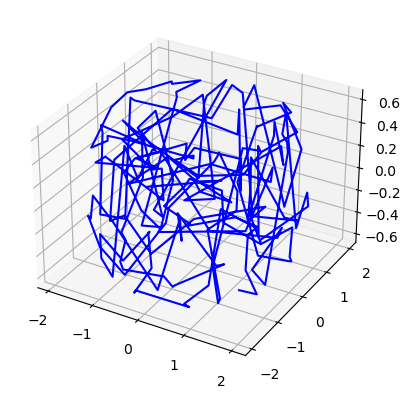

In [43]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = torus_bary[:,0]
Y = torus_bary[:,1]
Z = torus_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

# Persistent homology of sampled barycenters

/tmp/ipykernel_45793/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


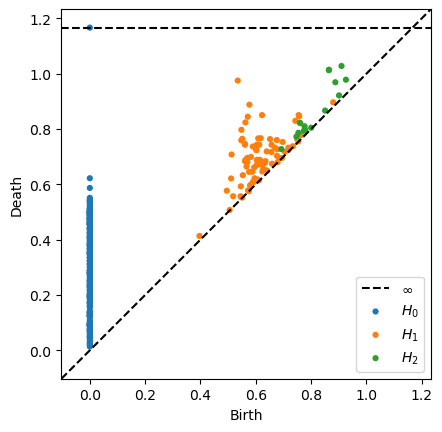

In [44]:
torus_PH_arrays,PH_diagram_barycenters_torus = get_persistence_diagram(torus_bary,2)

# Sphere

In [25]:
expr = x**2 + y**2 + z**2 - 1
poly = sp.Poly(expr, x, y, z)

In [26]:
expr

x**2 + y**2 + z**2 - 1

In [27]:
    # convert sympy polynomial to minyterpy polynomial
newt_poly = sympy_to_mp(poly, mp.NewtonPolynomial)

In [28]:
#sample points
point_data = sample_points_on_poly(1000,        # Number of points to be sampled
                                   newt_poly,  # Polynomial in Newton basis
                                   bounds=1, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [29]:
point_data.shape

(1000, 3)

In [30]:

x_so = point_data[:,0]

y_so = point_data[:,1]

z_so = point_data[:,2]


plot_points = [x_so,y_so,z_so]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [31]:
sphere_bary = get_convergent_barycenters(point_data, 50, point_data[0])

In [32]:
sphere_bary.shape

torch.Size([50, 3])

# Trajectory of barycenter smpling on sphere


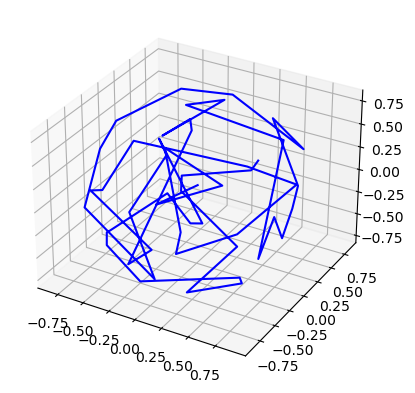

In [33]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = sphere_bary[:,0]
Y = sphere_bary[:,1]
Z = sphere_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

In [34]:
x_sb = sphere_bary[:,0]#.cpu().detach().numpy()

y_sb = sphere_bary[:,1]#.cpu().detach().numpy()

z_sb = sphere_bary[:,2]#.cpu().detach().numpy()



plot_points = [x_sb,y_sb,z_sb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

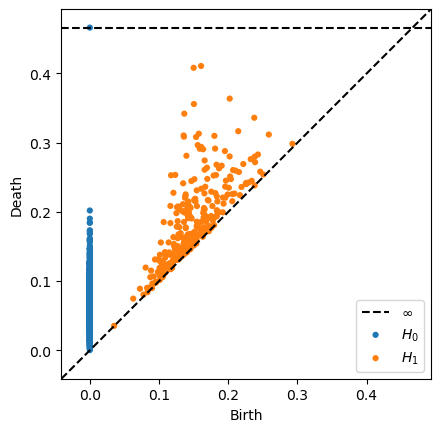

In [35]:
#original point cloud sphere persistence diagram

PH_diagram_spheres = get_persistence_diagram(point_data,1)

/tmp/ipykernel_45793/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


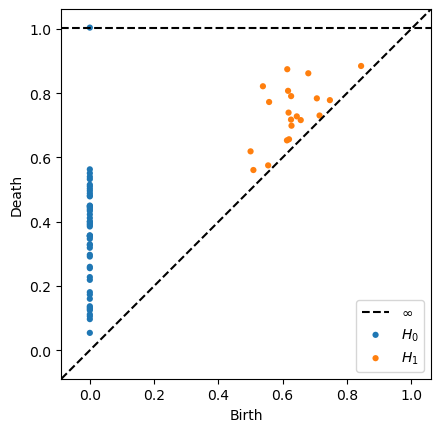

In [36]:
# barycentyers of sphere persistence diagram


PH_diagram_barycenters_sphere = get_persistence_diagram(sphere_bary, 1)